In [46]:
import os 
import glob 
import xarray as xr 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import shutil
from scipy.stats import linregress
import cartopy.io.shapereader as shpreader
from shapely.geometry import shape
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
from shapely.prepared import prep
import regionmask
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
import xesmf as xe
from matplotlib.ticker import ScalarFormatter
from shapely.geometry import Point
import matplotlib.cm as cm
import calendar
from collections import Counter
import itertools
import rasterio
import struct
from datetime import datetime, timedelta
from tqdm import tqdm
import subprocess
import urllib.request
import zipfile

# Set global font to a sans-serif type suitable for publishing
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],  # Use 'Helvetica' or 'DejaVu Sans' if Arial is unavailable
    'font.size': 8,               # Default font size
    'axes.titlesize': 8,          # Title font size
    'axes.labelsize': 8,          # X and Y labels font size
    'xtick.labelsize': 8,         # X-axis tick labels font size
    'ytick.labelsize': 8,         # Y-axis tick labels font size
    'legend.fontsize': 8,         # Legend font size
    'figure.titlesize': 8         # Figure title font size
})

ModuleNotFoundError: No module named 'cartopy'

# Change inputs

Files structure is .$home/PRISM/{var_name}/netdf

In [27]:
# home = '/home/ib28/mymount/sd75/isabelleb/wastewater/PRISM'
home = '/home/sd96/rdf'
# home = '/home/sd96/wastewater'
# shapefile = os.path.join(home, 'harris_county.geojson')
shapefile = os.path.join(home, 'tl_2024_us_state', 'tl_2024_us_state.shp')
# shapefile = "/home/ib28/mymount/sd75/isabelleb/wastewater/shapefiles/Regional_County_Boundaries.shp"

# Downloading BIL Files from PRISM 

    Saves zip files in rdf in folders `zip_ppt`, `zip_tmean`, `zip_tdmean`
    Saves unziped files in rdf folders `ppt`, `tmean`, `tdmean`

In [31]:
daily = "D2"
monthly = "M3"
clim_var = "ppt"
folder = os.path.join(home, f'zip_{clim_var}')
base_url = "https://services.nacse.org/prism/data/public/4km"
start = datetime.strptime("2020-01-01", "%Y-%m-%d")
stop = datetime.strptime("2024-12-31", "%Y-%m-%d")

NameError: name 'datetime' is not defined

In [ ]:
# def _progress_hook(block_num, block_size, total_size, t):
#     """
#     Callback function to update tqdm progress bar during file download.
#     """
#     downloaded = block_num * block_size
#     if total_size > 0:
#         t.update(min(block_size, total_size - t.n))
#     else:
#         t.update(downloaded - t.n)

# while start <= stop:
#     day = start.strftime("%Y%m%d")
#     url = f"{base_url}/{clim_var}/{day}"
#     output_file = os.path.join(folder, day)

#     with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=f'Downloading {day}') as t:
#         urllib.request.urlretrieve(url, output_file, reporthook=lambda block_num, block_size, total_size: _progress_hook(block_num, block_size, total_size, t))

#     start += timedelta(days=1)

In [ ]:
def parse_header(hdr_path):
    """Parses a .hdr file and returns a dictionary of header information."""
    header = {}
    with open(hdr_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                header[parts[0].upper()] = parts[1]
    return header

def read_bil_manual(bil_path, hdr_path):
    """
    Reads a .bil file manually using information from its .hdr file.
    """
    header = parse_header(hdr_path)

    nrows = int(header.get('NROWS', 0))
    ncols = int(header.get('NCOLS', 0))
    nbits = int(header.get('NBITS', 0))
    byteorder = header.get('BYTEORDER', 'I') # 'I' for Intel (little-endian), 'M' for Motorola (big-endian)
    pixeltype = header.get('PIXELTYPE', 'SIGNEDINT') # Example: FLOAT, SIGNEDINT, UNSIGNEDINT

    # Determine data type for struct and numpy
    if nbits == 8:
        dtype = np.int8 if pixeltype == 'SIGNEDINT' else np.uint8
        fmt_char = 'b' if pixeltype == 'SIGNEDINT' else 'B'
    elif nbits == 16:
        dtype = np.int16 if pixeltype == 'SIGNEDINT' else np.uint16
        fmt_char = 'h' if pixeltype == 'SIGNEDINT' else 'H'
    elif nbits == 32:
        if pixeltype == 'FLOAT':
            dtype = np.float32
            fmt_char = 'f'
        else:
            dtype = np.int32 if pixeltype == 'SIGNEDINT' else np.uint32
            fmt_char = 'i' if pixeltype == 'SIGNEDINT' else 'I'
    else:
        raise ValueError(f"Unsupported NBITS: {nbits}")

    endian_prefix = '<' if byteorder == 'I' else '>' # Little-endian or Big-endian

    with open(bil_path, 'rb') as f:
        bil_data = f.read()

    # Unpack binary data
    num_elements = nrows * ncols
    format_string = f"{endian_prefix}{num_elements}{fmt_char}"
    unpacked_data = struct.unpack(format_string, bil_data)

    # Reshape into a 2D array
    data_array = np.array(unpacked_data, dtype=dtype).reshape(nrows, ncols)

    return data_array

# Example usage:
bil_file = os.path.join(home, f'{clim_var}', f'PRISM_{clim_var}_stable_4km{daily}_20210101_bil.bil') 
hdr_file = os.path.join(home, f'{clim_var}', f'PRISM_{clim_var}_stable_4km{daily}_20210101_bil.hdr') 
bil_data_manual = read_bil_manual(bil_file, hdr_file)

In [ ]:
# Read raster data from .bil file
bil_file_path = os.path.join(home, f'{clim_var}', f'PRISM_{clim_var}_stable_4km{daily}_20210101_bil.bil') 

# Use rasterio to read the raster data
with rasterio.open(bil_file_path) as src:
    raster_data = src.read(1)
    transform = src.transform

# Visualize data on the map
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the desired minimum and maximum values for the colormap
vmin = 0  
vmax = 100  

# Plot the raster data using imshow with vmin and vmax
im = ax.imshow(raster_data, extent=(transform[2], transform[2] + transform[0] * raster_data.shape[1],
                                    transform[5] + transform[4] * raster_data.shape[0], transform[5]),
               origin='upper', cmap='viridis', alpha=0.5, vmin=vmin, vmax=vmax)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.1, shrink=0.4)
cbar.set_label('Raster Value')

# Add gridlines and coastlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.coastlines()

# Set aspect ratio to 'equal'
ax.set_aspect('equal')

plt.show()

In [ ]:
# Convert the data into an xarray dataset 

def create_array_with_step(N, start_value, step): 
    result_array = []
    for i in range(N): 
        result_array.append(start_value + i * step) 
    return np.array(result_array)

header_data = parse_header(hdr_file)
x0 = float(header_data['ULXMAP'])
y0 = float(header_data['ULYMAP'])
dx = float(header_data['XDIM'])
dy = float(header_data['YDIM'])
    
Nx = raster_data.shape[1]
Ny = raster_data.shape[0]
# dx = transform[0]
# dy = transform[4]
# x0 = transform[2]
# y0 = transform[5] 
    
longitude = create_array_with_step(Nx, x0, dx)
latitude = create_array_with_step(Ny, y0, -dy) 
filename_parts = bil_file_path.split('.')[0].split('_') 

# Daily 
timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m%d')]) 

# Monthly 
# timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m')]) 
var_data = np.expand_dims(raster_data, axis=2)

In [ ]:
ds = xr.Dataset(
    data_vars=dict(
        tmean=(('lat', 'lon', 'time'), var_data),
    ),
    coords=dict(
        lon=('lon', longitude),
        lat=('lat', latitude),
        time=('time', timestamp), 
    ),
    attrs=dict(description="PRISM data"),
)

In [ ]:

plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
levels = np.arange(-10, 31, 1) 
ds = ds.sortby('lat') 
ds_plot = ds.sel(lat = slice(25, 37), lon = slice(-107, -93)) 
ds_plot = ds_plot.where(ds_plot.tmean > -8000, drop = True) 
levels = np.arange(-18, 19, 1)
ds_plot.sel(time = '20210101').tmean.plot(x = 'lon', y = 'lat', ax = ax, levels = levels)

# shapefile = '/home/ib28/mymount/sd75/isabelleb/BWF_Pres/tl_2024_us_state.shp'
shapefile = os.path.join(home, 'tl_2024_us_state', 'tl_2024_us_state.shp')
states = gpd.read_file(shapefile)

##### Filter for Texas #####
texas = states[states['NAME'] == 'Texas']

##### Plot Texas Boundary #####
texas.boundary.plot(ax=ax, color='black', alpha = 0.5, linewidth=1)

# Read all datasets into NetCDF format

In [ ]:
def parse_header(hdr_file_path):
    """Parses a .hdr file and returns a dictionary of header information."""
    header = {}
    with open(hdr_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                header[parts[0].upper()] = parts[1]
    return header

def parse_bil(bil_file_path): 
    # Use rasterio to read the raster data
    with rasterio.open(bil_file_path) as src:
        raster_data = src.read(1)
    return raster_data       

def create_array_with_step(N, start_value, step): 
    result_array = []
    for i in range(N): 
        result_array.append(start_value + i * step) 
    return np.array(result_array)

In [ ]:
variables = ['tmean', 'tdmean', 'ppt'] 
years = ['2020', '2021', '2022', '2023', '2024']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
start = datetime.strptime("2020-01-01", "%Y-%m-%d")
stop = datetime.strptime("2024-12-31", "%Y-%m-%d")

for var in variables:
    
    homedir = f'{var}'

    outdir = os.path.join(home, homedir, 'netcdf') 
    if os.path.exists(outdir) == False: 
        os.mkdir(outdir) 

    print("Start date", start, "Stop date", stop)
    curr_date = start
    while curr_date <= stop:
        day = curr_date.strftime("%Y%m%d")

        bil_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4km{daily}_{day}_bil.bil') 
        hdr_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4km{daily}_{day}_bil.hdr') 
            
            # TODO: Add days 
#         bil_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4kmM3_{year}{m}_bil.bil') 
#             hdr_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4kmM3_{year}{m}_bil.hdr') 
    
        outfile = os.path.join(home, outdir, f'PRISM_{var}_stable_4km{daily}_{day}.nc')
        
        if os.path.exists(bil_file) and os.path.exists(hdr_file):
            # Read in raster data 
            raster_data = parse_bil(bil_file) 
            Nx = raster_data.shape[1]
            Ny = raster_data.shape[0]

            # Read in header data 
            hdr_data = parse_header(hdr_file) 
            x0 = float(hdr_data['ULXMAP'])
            y0 = float(hdr_data['ULYMAP'])
            dx = float(hdr_data['XDIM'])
            dy = float(hdr_data['YDIM'])

            # Create coordinate arrays for dataset 
            longitude = create_array_with_step(Nx, x0, dx)
            latitude = create_array_with_step(Ny, y0, -dy) 
            filename_parts = bil_file.split('.')[0].split('_') 
            timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m%d')]) 
            var_data = np.expand_dims(raster_data, axis=2)

            # Create dataset 
            ds = xr.Dataset(
                data_vars=dict(
                    tmp=(('lat', 'lon', 'time'), var_data),
                ),
                coords=dict(
                    lon=('lon', longitude),
                    lat=('lat', latitude),
                    time=('time', timestamp), 
                ),
                attrs=dict(description=f"PRISM {var} data"),
            )
            ds = ds.rename({'tmp':var})

            # Save dataset 
            ds.to_netcdf(outfile) 
            print(f'Saved {outfile}')
            curr_date += timedelta(days=1)
        else: 
            print(f"File for {day} not found. Either {hdr_file} or {bil_file}")
            

In [ ]:
##### Read county shapefile from the HC Universal Services GIS Open Data Site #####
counties_shapefile_path = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties_shapefile = gpd.read_file(counties_shapefile_path)

shapefile = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties = gpd.read_file(shapefile)

# ##### Filter for HC #####
HC = counties[(counties.NAME == 'Harris') & (counties.STATEFP == '48')]

print(HC.geometry.bounds)
print(HC.geometry.crs) 

# Get values in Harris County 

In [ ]:
##### -------- Get KG Classes for Texas -------- #####

##### Read county shapefile from the HC Universal Services GIS Open Data Site #####
# counties = gpd.read_file(shapefile)
counties_shapefile_path = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties = gpd.read_file(counties_shapefile_path)

# ##### Filter for HC #####
# HC = counties[counties.NAME == 'Harris']
HC = counties[(counties.NAME == 'Harris') & (counties.STATEFP == '48')]

##### Read in files #####
# variables = ['tmean', 'tdmean', 'ppt'] 
variables = ['ppt'] 
for var in variables: 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    print(f"sorting file in directory {homedir}")
    files = glob.glob(os.path.join(home, homedir, 'PRISM*.nc'))
    files.sort() 

#     for f in files: 
    for f in tqdm(files, desc=f"Processing {var}", unit="file"):

        filename = f.split('/')[-1].split('.')[0]
        outfile = os.path.join(home, homedir, f'Harris_County_{filename}.nc') 
        
        if os.path.exists(outfile): 
            os.remove(outfile) 
            
        with xr.open_dataset(f) as ds: 

            # Limit file 
            ds = ds.sortby('lat') 
            ds = ds.sel(lon = slice(-96.5, -94.5), lat = slice(29.1, 30.5))
            
            # Get the lat/lon coordinates
            lats = ds['lat'].values
            lons = ds['lon'].values
    
            # Create a 2D mesh of coordinates
            lon2d, lat2d = np.meshgrid(lons, lats)
    
            # Flatten the mesh for easier masking
            points = np.array([Point(xy) for xy in zip(lon2d.ravel(), lat2d.ravel())])
    
            # Check which points fall inside the HC polygon
            within_HC = np.array([HC.geometry.iloc[0].contains(p) for p in points])
            mask = within_HC.reshape(lat2d.shape)
    
            # Apply mask to data
            # If 3D (time, lat, lon)
            if "time" in ds.dims:
                mask = np.expand_dims(mask, axis=2)
                masked = ds.where(mask)
            else:
                # 2D (lat, lon)
                masked = ds.where(mask)
            
            # Save data 
            valid_points = masked[var].count().values
            # print(f"\tValid points in {var}: {valid_points}")

            print(f"\tSaved ({valid_points}): {outfile}")
            masked.to_netcdf(outfile) 

In [ ]:
# Plot the Harris County data for 202101 to check 
HC_bounds = [-96.1, -94.8, 29.45, 30.25]

var = 'ppt'
date = '20210214'
year = date[:4]
mon = date[4:]
datestr = f'{date}'

shapefile = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties = gpd.read_file(shapefile)

fig, ax = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize = (8, 5))

# ax.set_xlim(HC_bounds[0], HC_bounds[1]) 
# ax.set_ylim(HC_bounds[2], HC_bounds[3]) 

# Plot tmean 
infile = os.path.join(home, f'{var}', 'netcdf', f'Harris_County_PRISM_{var}_stable_4km{daily}_{date}.nc') 
print(f'infile {infile}')
ds = xr.open_dataset(infile) 
ds = ds.sel(time = datestr, lon = slice(HC_bounds[0], HC_bounds[1]), lat = slice(HC_bounds[2], HC_bounds[3]))
vmin = float(ds[var].min())
vmax = float(ds[var].max())
levels = np.linspace(vmin, vmax, 20)
# levels = np.arange(11, 13.6, 0.1) 
CS = ds[var].plot(x = 'lon', y = 'lat', ax = ax[0], add_colorbar = False, levels = levels) 
CS = ds[var].plot.contourf(x = 'lon', y = 'lat', ax = ax[1], add_colorbar = False, levels = levels) 
ax[0].set_title('xarray plot method') 
ax[1].set_title('xarray countourf method') 

print(np.isnan(ds[var].values).sum())  # Count NaNs

# Plot HC boundary 
for i in range(2): 
    counties = gpd.read_file(shapefile)
    HC = counties[(counties.NAME == 'Harris') & (counties.STATEFP == '48')]
    HC.boundary.plot(ax = ax[i]) 
    
    # Plot Characteristics 
    ax[i].axis('off') 
plt.colorbar(CS, ax = ax, orientation = 'horizontal', pad = 0.04, label = r'$T$ [$^\circ$C]') 
plt.suptitle(f'{year}-{mon} Mean Daily {var} in Harris County', y=0.77, fontsize = 10) 

In [ ]:
infile = os.path.join(home, f'{var}', 'netcdf', f'Harris_County_PRISM_{var}_stable_4km{daily}_{date}.nc') 
print(f'infile {infile}')
ds = xr.open_dataset(infile) 

print("Min:", ds[var].min().item())
print("Max:", ds[var].max().item())
print("NaNs:", np.isnan(ds[var].values).sum())

ds = xr.open_dataset(infile)
print(ds[var].mean(dim=['lat', 'lon'], skipna=True))


# Time series of variables averaged over Harris County 

In [11]:
import os
import glob 
import xarray as xr
def weighted_mean(ds, lat_name, lon_name): 
    lats = ds[lat_name]
    weights = np.cos(np.deg2rad(lats)) 
    weights.name = "weights"

    ds_weighted = ds.weighted(weights) 
    ds_weighted_mean = ds_weighted.mean([lon_name, lat_name]) 

    return ds_weighted_mean 

In [12]:
variables = ['tmean', 'tdmean', 'ppt'] 
# variables = ['ppt'] 
years = ['2020', '2021', '2022', '2023', '2024'] 
for var in variables: 
    for year in years: 
        homedir = os.path.join(home, f'{var}', 'netcdf') 
        files = glob.glob(os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}*.nc'))
        files.sort() 
    
        ds = xr.open_mfdataset(files, concat_dim = 'time', combine = 'nested').load() 
    
        outfile = os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}.nc')
           
        if os.path.exists(outfile): 
            os.remove(outfile) 
            
        ds.to_netcdf(outfile) 

ValueError: 'lon' not present in all datasets and coords='different'. Either add 'lon' to datasets where it is missing or specify coords='minimal'.

In [ ]:
variables = ['tmean', 'tdmean', 'ppt'] 
colors = ['orange', 'green', 'blue'] 
years = ['2020', '2021', '2022', '2023', '2024'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 

for i, var in enumerate(variables): 
    color = colors[i]
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        files.append(os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}.nc')) 
        
    ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested') 

    if 'time' in ds.sizes and ds.sizes['time'] == 366:
        ds = ds.transpose('time', 'lat', 'lon')
    # Get mean 
    ds_mean = weighted_mean(ds, 'lat', 'lon')
    
    if var == 'ppt': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(color)
        twin1.tick_params(axis='x', colors=color)
        twin1.tick_params(axis='y', colors=color)
        twin1.set_ylabel('Precpiptation [mm]', color = color) 
    else: 
        axplot = ax

    # Plot 
    ds_mean[var].plot(x = 'time', ax = axplot, color=color, alpha = 0.7) 
#     ds_mean[var].plot.scatter(x = 'time', ax = axplot, color=color, alpha = 0.7) 
        
# Add a legend manually if needed
labels = ['$T_{s}$', r'$T_{dp}$', r'$P$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10) 
twin1.set_ylabel('Precpiptation [mm]', color = color)
plt.savefig('plots/daily_ts_tmean_tdmean_ppt')

# Back Calculate Relative Humidity

In [ ]:
def rel_humidity(tas, tdp): 
    ''' 
    Calculates relative humidty (%) using the Mangus approximation 

    Inputs:
    tas - surface temperature (C)
    tdp - dew point temperature (C)

    Outputs:
    hurs - surface relative humidity (%)
    '''
    # Constants
    c1 = 17.625
    c2 = 243.04
    
    print(tdp.shape)
    print(tas.shape)
    # Mangus Forumla
    hurs = 100*(np.exp((c1*tdp)/(c2+tdp))/np.exp((c1*tas)/(c2+tas)))

    return hurs 


def rel_humidity_safe(tas, tdp):
    """
    Calculate relative humidity avoiding coordinate alignment issues
    """
    c1 = 17.625
    c2 = 243.04
    
    print('Input tas shape:', tas.shape)
    print('Input tdp shape:', tdp.shape)
    
    # Work directly with values to avoid coordinate issues
    numerator_vals = np.exp((c1 * tdp.values) / (c2 + tdp.values))
    denominator_vals = np.exp((c1 * tas.values) / (c2 + tas.values))
    
    hurs_vals = 100 * (numerator_vals / denominator_vals)
    
    print('Calculated hurs_vals shape:', hurs_vals.shape)
    
    # Create new DataArray using coordinates from tas (or tdp - they should be the same)
    hurs = xr.DataArray(
        hurs_vals,
        coords={
            'lat': tas.lat,
            'lon': tas.lon, 
            'time': tas.time
        },
        dims=['lat', 'lon', 'time'],
        name='hurs',
        attrs={'units': '%', 'long_name': 'Surface Relative Humidity'}
    )
    
    print('Final hurs shape:', hurs.shape)
    return hurs



In [ ]:
outdir = os.path.join(home, 'netcdf', 'hurs')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 
outdir = os.path.join(outdir, 'netcdf')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 

for year in years: 

    files_tmean = glob.glob(os.path.join(home, 'tmean', 'netcdf', f'Harris_County_PRISM_tmean_stable_4km{daily}_{year}.nc'))
    files_tmean.sort() 
    files_tdmean = glob.glob(os.path.join(home, 'tdmean', 'netcdf', f'Harris_County_PRISM_tdmean_stable_4km{daily}_{year}.nc'))
    files_tdmean.sort() 

    ds_tmean = xr.open_mfdataset(files_tmean, concat_dim = 'time', combine = 'nested').load() 
    ds_tdmean = xr.open_mfdataset(files_tdmean, concat_dim = 'time', combine = 'nested').load() 

    outfile = os.path.join(outdir, f'Harris_County_PRISM_hurs_stable_4km{daily}_{year}.nc')

    # Calculate relhum: 
    ds_hurs = rel_humidity(ds_tmean.tmean, ds_tdmean.tdmean)

    # Save as netcdf 
    ds_hurs = ds_hurs.to_dataset(name = 'hurs')
    ds_hurs.to_netcdf(outfile)
    

In [ ]:
years = ['2020', '2021', '2022', '2023', '2024'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
var = 'hurs'

homedir = os.path.join(home, f'{var}', 'netcdf') 
files = []
for year in years: 
    files.append(os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}.nc')) 

ds = xr.open_mfdataset(files, concat_dim='time', combine='nested', engine='netcdf4')

# ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested') 

# Get mean 
ds_mean = weighted_mean(ds, 'lat', 'lon')

# Plot 
ds_mean[var].plot(x = 'time', ax = ax, color='purple', alpha = 0.7, label = r'$r$') 
# ds_mean[var].plot.scatter(x = 'time', ax = ax, color='purple', alpha = 0.7) 


# ax.legend(loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
ax.set_ylabel(r'Relative Humidity [%]') 
ax.grid() 
ax.set_title('Relative Humidity over Harris County', fontsize = 10) 
plt.savefig('plots/daily_ts_hurs')

# Calculate wet bulb temperature 

In [1]:
def stull_wet_bulb_temp(tas, hurs):
    '''
    Calculates the approximation for wet bulb temperature developed by Stull et al (2011)

    Inputs:
    tas - surface temperature (C)
    hurs - relative humidity (%)

    Outputs:
    twbs - wet bulb temperature (C)
    '''

    # Constants
    c1 = 0.151977
    c2 = 8.313659
    c3 = 1.676331
    c4 = 0.00391838
    c5 = 0.023101
    c6 = 4.686035

    # Calculate wet bulb temperature
    twbs = tas * np.arctan(c1 * (hurs + c2)**(0.5)) + np.arctan(tas + hurs) - np.arctan(hurs - c3) + c4 * (hurs)**(1.5) * np.arctan(c5 * hurs) - c6

    return twbs


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
# outdir = 'twbs'
outdir = os.path.join(home, 'twbs')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 
outdir = os.path.join(outdir, 'netcdf')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir)     

print(outdir)

for year in years: 
#     print(os.path.join(home, 'tmean', 'netcdf', f'Harris_County_PRISM_tmean_stable_4kmY2_{year}.nc'))
    print("Looking for:", os.path.join(home, 'hurs', 'netcdf', f'Harris_County_PRISM_hurs_stable_4km{daily}_{year}.nc'))

    files_tmean = glob.glob(os.path.join(home, 'tmean', 'netcdf', f'Harris_County_PRISM_tmean_stable_4km{daily}_{year}.nc'))
    
    files_tmean.sort() 
    files_hurs = glob.glob(os.path.join(home, 'hurs', 'netcdf', f'Harris_County_PRISM_hurs_stable_4km{daily}_{year}.nc'))
    files_hurs.sort() 

    ds_tmean = xr.open_mfdataset(files_tmean, concat_dim = 'time', combine = 'nested').load() 
    ds_hurs = xr.open_mfdataset(files_hurs, concat_dim = 'time', combine = 'nested').load() 

    outfile = os.path.join(home, outdir, f'Harris_County_PRISM_twbs_stable_4km{daily}_{year}.nc')

    # Calculate relhum: 
    ds_twbs = stull_wet_bulb_temp(ds_tmean.tmean, ds_hurs.hurs)

    # Save as netcdf 
    ds_twbs = ds_twbs.to_dataset(name = 'twbs')
    ds_twbs.to_netcdf(outfile)
    

NameError: name 'os' is not defined

In [ ]:
years = ['2020', '2021', '2022', '2023'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
variables = ['twbs', 'tmean', 'hurs'] 
colors = ['red', 'orange', 'purple']

for i, var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        filepath = os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}.nc')
        if os.path.exists(filepath):
            files.append(filepath)
        else:
            print(f"Missing file for {var}, year {year}: {filepath}")

    if not files:
        print(f"No files found for variable '{var}', skipping...")
        continue

    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
    ds_mean = weighted_mean(ds, 'lat', 'lon')

    if var == 'hurs': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(colors[i])
        twin1.tick_params(axis='x', colors=colors[i])
        twin1.tick_params(axis='y', colors=colors[i])
    else: 
        axplot = ax

    # Plot 
    ds_mean[var].plot(x='time', ax=axplot, color=colors[i], alpha=0.7) 
#     ds_mean[var].plot.scatter(x='time', ax=axplot, color=colors[i], alpha=0.7)


labels = ['$T_{wbs}$', r'$T_{s}$', r'$r$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
twin1.set_ylabel(r'Relative Humidity [%]', color = colors[2]) 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10)
plt.savefig('plots/daily_ts_twbs_tmean_hurs')


In [ ]:
years = ['2020', '2021', '2022', '2023', '2024'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
variables = ['twbs', 'tmean', 'hurs'] 
colors = ['red', 'orange', 'purple']
for i, var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        filepath = os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4kmY2_{year}.nc')
        if os.path.exists(filepath):
            files.append(filepath)
        else:
            print(f"Missing file for {var}, year {year}: {filepath}")
    if not files:
        print(f"No files found for variable '{var}', skipping...")
        continue
    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
    ds_mean = weighted_mean(ds, 'lat', 'lon')
    if var == 'hurs': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(colors[i])
        twin1.tick_params(axis='x', colors=colors[i])
        twin1.tick_params(axis='y', colors=colors[i])
    else: 
        axplot = ax
    # Plot only lines (removed scatter plot)
    ds_mean[var].plot(x='time', ax=axplot, color=colors[i], alpha=0.8, linewidth=1)

labels = ['$T_{wbs}$', r'$T_{s}$', r'$r$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
twin1.set_ylabel(r'Relative Humidity [%]', color = colors[2]) 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10)

# Combine files from 2020 to 2023 for twbs, tmean, hurs, and ppt

In [68]:
import numpy as np
years = ['2020', '2021', '2022', '2023'] 
variables = ['twbs', 'tmean', 'hurs', 'ppt', 'tdmean'] 
mean_files = {}
for i, var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        filepath = os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4kmD2_{year}.nc')
        if os.path.exists(filepath):
            files.append(filepath)
        else:
            print(f"Missing file for {var}, year {year}: {filepath}")
    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
    ds_mean = weighted_mean(ds, 'lat', 'lon')
    mean_files[var] = ds_mean

    outfile = os.path.join(home, f'Harris_County_PRISM_weighted_mean_{var}_stable_4kmD2_{years[0]}_{years[-1]}.nc')
    ds_mean.to_netcdf(outfile) 
    ds_check = xr.open_dataset(outfile)
    print(ds_check)
    print(ds_check.coords)

    print(f"Saved file for {var} at {outfile}")

<xarray.Dataset> Size: 23kB
Dimensions:  (time: 1461)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2020-01-01 2020-01-02 ... 2023-12-31
Data variables:
    tdmean   (time) float64 12kB ...
Coordinates:
  * time     (time) datetime64[ns] 12kB 2020-01-01 2020-01-02 ... 2023-12-31
Saved file for tdmean at /home/sd96/rdf/Harris_County_PRISM_weighted_mean_tdmean_stable_4kmD2_2020_2023.nc


# Combine with COVID Data

In [69]:
import xarray as xr
import os

years = ['2020', '2021', '2022', '2023'] 
variables = ['twbs', 'tmean', 'hurs', 'ppt', 'tdmean']

datasets = []
for var in variables:
    outfile = os.path.join(
        home,
        f'Harris_County_PRISM_weighted_mean_{var}_stable_4kmD2_{years[0]}_{years[-1]}.nc'
    )
    ds = xr.open_dataset(outfile)
    datasets.append(ds)

# Merge into one dataset
ds_combined = xr.merge(datasets)

# Convert to pandas DataFrame
df_weather_vars = ds_combined.to_dataframe().reset_index()

print(df_weather_vars.head())

outfile_csv = os.path.join(
    home,
    f"Harris_County_PRISM_D2_weighted_mean_weather_vars_2020_2023.csv"
)
df_weather_vars = df_weather_vars.set_index("time")
df_weather_vars.to_csv(outfile_csv)

print(f"Saved combined weather variables to {outfile_csv}")


        time       twbs      tmean       hurs       ppt     tdmean
0 2020-01-01   4.903825   9.140190  56.148792  0.000000   0.846825
1 2020-01-02  11.234624  13.356091  80.767583  4.966381  10.115235
2 2020-01-03  14.967619  15.114837  98.920041  4.764033  14.945209
3 2020-01-04  10.178196  13.313961  71.277026  0.000000   8.204920
4 2020-01-05   7.844572  12.585919  55.085360  0.000000   3.798379
Saved combined weather variables to /home/sd96/rdf/Harris_County_PRISM_weighted_mean_weather_vars_2020_2023.csv


In [79]:
# Load and prepare COVID dataset
df_covid_full = pd.read_csv(
    os.path.join(home, "sarscov2ww_ricehhd.csv")
)
df_covid_full.rename(columns={'date': 'Date'}, inplace=True)
df_covid_full['Date'] = pd.to_datetime(df_covid_full['Date'])

df_covid = df_covid_full[df_covid_full['WWTP'] == 'TOTAL']
df_covid = df_covid[['Date', 'Spline_WW', 'Spline_PR']]

df_covid.set_index('Date', inplace=True)
df_covid.index = pd.to_datetime(df_covid.index)

print("COVID:", df_covid.index.min(), "to", df_covid.index.max())

# Merge COVID data with all climate variables
df_covid_weather_vars = df_weather_vars.join(df_covid, how='left')
print("df_covid_weather_vars:", df_covid_weather_vars.index.min(), "to", df_covid_weather_vars.index.max())
print(df_covid_weather_vars.columns)
df_covid_weather_vars.head(300)

outfile_csv = os.path.join(
    home,
    f"Harris_County_Daily_PRISM_weighted_mean_weather_vars_COVID_2020_2023.csv"
)
# df_covid_weather_vars = df_covid_weather_vars.set_index("time")
df_covid_weather_vars.to_csv(outfile_csv)

print(f"Saved combined COVID and weather variables to {outfile_csv}")


COVID: 2020-07-06 00:00:00 to 2022-04-25 00:00:00
df_covid_weather_vars: 2020-01-01 00:00:00 to 2023-12-31 00:00:00
Index(['twbs', 'tmean', 'hurs', 'ppt', 'tdmean', 'Spline_WW', 'Spline_PR'], dtype='object')
Saved combined COVID and weather variables to /home/sd96/rdf/Harris_County_Daily_PRISM_weighted_mean_weather_vars_COVID_2020_2023.csv


# Correlation Analysis

In [53]:
def create_lagged_features(df, weather_vars, max_lags=6, interval_size=1, dropna=False):
    """
    Create lagged features for weather variables for each the weather vars passed
    Creates columns named as ['Precip_lag1', 'Precip_lag2', ...]
    By default, it drops the NaN values and returns a new DF

    """
    df_lagged = df.copy()


    for var in weather_vars:
        for lag in range(0, max_lags + 1):
            shift_amount = lag * interval_size
            df_lagged[f'{var}_lag{shift_amount}'] = df_lagged[var].shift(shift_amount)

    if dropna:
        df_lagged = df_lagged.dropna()
    return df_lagged

## Plot Single Correlation

In [49]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import shapiro
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
def plot_lagged_correlations(df_merged, weather_variable, covid_variable,
                             interval_size, number_of_intervals, time_unit="Days",
                             # lags={"0 days": 0, "7 days": 7, "14 days": 14, "21 days": 21, "28 days": 28, "35 days": 35},
                             file_name_suffix = '', wwtp_plant_and_station_name='', save_path='plots'):

    stat, p = shapiro(df_merged[weather_variable]) 
    print('Shapiro-Wilk p-value:', p)
    lags = {}
    for i in range(0, number_of_intervals + 1): 
        lags[f'{i * interval_size} {time_unit}'] = i * interval_size

    print(lags)

    df_merged = create_lagged_features(df_merged, [weather_variable], max_lags=number_of_intervals, interval_size=interval_size) 

    print("df_merged", df_merged.index.min(), "to", df_merged.index.max())
    # print(df_merged.columns)

    correlations = {}
    p_values = {}
    
    for lag in lags.values():

        lagged_col = f"{weather_variable}_lag{lag}"

        temp = df_merged[[covid_variable, lagged_col]].dropna()
            
        corr, p = spearmanr(temp[covid_variable], temp[lagged_col])
    
        correlations[lag] = corr
        p_values[lag] = p

    x = list(lags.values())
    y = [correlations[lag] for lag in x]

    # plot correlations
    num_lags = len(lags)
    fig_width = max(8, num_lags * 0.5)
    plt.figure(figsize=(fig_width, 5))
    plt.plot(x, y, marker='o', label=covid_variable)

    # add annotations to each point with p values
    for i, lag in enumerate(lags.values()):
        r = correlations[lag]
        p = p_values[lag]
    
        color = "green" if p < 0.05 else "black"  
        plt.annotate(f"{r:.3f}", (lag, r), textcoords="offset points", xytext=(4, -12), ha='left', fontsize=8, color=color)        
    
    plt.xlabel(f"lag ({time_unit})")
    plt.xticks(list(lags.values()))
    plt.ylabel("Correlation")
    plt.title(f"Lag Correlations of {weather_variable} vs {covid_variable} {file_name_suffix}")
    plt.legend()
    plt.grid(True)

    # Print results 
    # for lag in lags.values():
    #     print(f"Lag {lag} {time_unit}:")
    #     print(f"  {covid_variable}: r = {correlations[lag]:.3f}, p = {p_values[lag]:.3f}")

    filename = ''
    time_span = "Monthly" if time_unit == "Months" else "Daily"
    if file_name_suffix: 
        filename = os.path.join(save_path, f"{time_span}_{weather_variable}_{covid_variable}_Lagged_Correlation_{file_name_suffix}.png")
    else:
        filename = os.path.join(save_path, f"{time_span}_{weather_variable}_{covid_variable}_Lagged_Correlation.png")

    # Save the plot
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Plot saved: {filename}")
    plt.show()
    
    # Save top lags for wastewater
    top_lags = [lag for lag, r in correlations.items() if abs(r) > 0.3]

    print("Top lags:", top_lags)
    
    cols = [covid_variable] + [f"{weather_variable}_lag{lag}" for lag in top_lags]

    return df_merged


## Plot All Correlations

In [50]:
import matplotlib.colors as mcolors

def darken(color, amount=0.6):
    """Darken a given matplotlib color by multiplying RGB by amount."""
    c = mcolors.to_rgb(color)
    return (c[0]*amount, c[1]*amount, c[2]*amount)


In [51]:
def plot_lagged_correlations_multi(df_merged, weather_variables, covid_variable,
                                   interval_size, number_of_intervals, time_unit="Days",
                                   file_name_suffix='', save_path='plots'):

    TITLE_LABELS = {'ppt': 'Precipitation', 
                    'tmean': 'Temperature', 
                    'twbs': 'Wet Bulb Temperature', 
                   'hurs': 'Relative Humidity', 
                   'Spline_WW': 'Viral Load', 
                   'Spline_PR': 'Positivity Rate'}
    
    
    FIG_LABELS = {'ppt': r'$P$', 
                  'tmean': r'$T_{s}$', 
                  'twbs': r'$T_{wbs}$',
                 'hurs': r'$r$'}


    # define lags
    lags = {f'{i * interval_size} {time_unit}': i * interval_size
            for i in range(0, number_of_intervals + 1)}

    # create lagged features for all weather variables
    df_merged = create_lagged_features(df_merged, weather_variables,
                                       max_lags=number_of_intervals,
                                       interval_size=interval_size) 

    print("df_merged", df_merged.index.min(), "to", df_merged.index.max())

    # setup plot
    num_lags = len(lags)
    fig_width = max(8, num_lags * 0.5)
    plt.figure(figsize=(fig_width, 5))

    # loop through weather variables
    for weather_variable in weather_variables:
        correlations = {}
        p_values = {}

        for lag in lags.values():
            lagged_col = f"{weather_variable}_lag{lag}"
            temp = df_merged[[covid_variable, lagged_col]].dropna()
            corr, p = spearmanr(temp[covid_variable], temp[lagged_col])
            correlations[lag] = corr
            p_values[lag] = p

        x = list(lags.values())
        y = [correlations[lag] for lag in x]

        # use FIG_LABELS for legend label
        label = FIG_LABELS.get(weather_variable, weather_variable)

         # pick a base line color automatically
        # plot line
        line, = plt.plot(x, y, label=label)  
        base_color = line.get_color()
        
        # black if significant, else same as line color
        colors = ['black' if p_values[lag] < 0.05 else base_color for lag in lags.values()]
        
        # scatter markers
        plt.scatter(x, y, c=colors, edgecolor=base_color, zorder=2)



    # finalize plot
    plt.xlabel(f"lag ({time_unit})")
    plt.xticks(list(lags.values()))
    plt.ylabel("Spearman Correlation")

    time_span = "Monthly" if time_unit == "Months" else "Daily"
    # use TITLE_LABELS if only one weather variable, otherwise generic
    if len(weather_variables) == 1:
        wvar = weather_variables[0]
        title_var = TITLE_LABELS.get(wvar, wvar)
        plt.title(f"{time_span} Lag Correlations for {title_var} vs {TITLE_LABELS[covid_variable]} {file_name_suffix}")
    else:
        plt.title(f"{time_span} Lag Correlations for Weather Variables vs {TITLE_LABELS[covid_variable]} {file_name_suffix}")

    plt.legend()
    plt.grid(True)

    # save
    if file_name_suffix: 
        filename = os.path.join(save_path, f"{time_span}_AllWeather_{covid_variable}_Lagged_Correlation_{file_name_suffix}.pdf")
    else:
        filename = os.path.join(save_path, f"{time_span}_AllWeather_{covid_variable}_Lagged_Correlation.pdf")

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Plot saved: {filename}")
    plt.show()

    return df_merged


## Constants & Load CSV

In [8]:
DAILY_PATH = "Harris_County_Daily_PRISM_weighted_mean_weather_vars_COVID_2020_2023.csv"
FINAL_PLOTS = "final_plots"
TMEAN = "tmean"
PPT = "ppt"
TDMEAN = "tdmean"
HURS = "hurs"
TWBS = "twbs"
SPLINE_WW = "Spline_WW"
SPLINE_PR = "Spline_PR"
DAILY = "daily"

TITLE_LABELS = {'ppt': 'Precipitation', 'tmean': 'Temperature', 'twbs': 'Wet Bulb Temperature', 
                'hurs': 'Relative Humidity', 'Spline_WW': 'Viral Load', 'Spline_PR': 'Positivity Rate'}
FIG_LABELS = {'ppt': r'$P$', 'tmean': r'$T_(s)$', 'twbs': r'$T_(wbs)$', 'hurs': r'$r$'}

# 'time', 'twbs', 'tmean', 'hurs', 'ppt', 'tdmean', 'Spline_PR',
DF_DAILY_COLS =  ['twbs', 'tmean', 'hurs', 'ppt', 'tdmean',
       'Spline_WW', 'Spline_PR', 'Spline_WW differenced']

In [45]:
import pandas as pd
import os

# Load CSV
df_daily_covid_weather = pd.read_csv(
    os.path.join(DAILY_PATH),
    index_col=0,           
    parse_dates=[0]  
)

# # Set time.1 column as the index, rename it to 'time', and drop the manual index column
# df_daily_covid_weather = df_daily_covid_weather.set_index("time.1").drop(columns=["time"])
# df_daily_covid_weather.index.name = "time"
df_daily_covid_weather["tmean_differenced"] = df_daily_covid_weather["tmean"].diff(1)
df_daily_covid_weather["ppt_differenced"] = df_daily_covid_weather["ppt"].diff(1)
# # Inspect
print(df_daily_covid_weather.head(500))

# df_daily_covid_weather.to_csv(DAILY_PATH, index=True)

                 twbs      tmean       hurs       ppt     tdmean  Spline_WW  \
time                                                                          
2020-01-01   4.903825   9.140190  56.148792  0.000000   0.846825        NaN   
2020-01-02  11.234624  13.356091  80.767583  4.966381  10.115235        NaN   
2020-01-03  14.967619  15.114837  98.920041  4.764033  14.945209        NaN   
2020-01-04  10.178196  13.313961  71.277026  0.000000   8.204920        NaN   
2020-01-05   7.844572  12.585919  55.085360  0.000000   3.798379        NaN   
...               ...        ...        ...       ...        ...        ...   
2021-05-10  24.041894  27.311371  76.499413  0.666382  22.813670  13.288331   
2021-05-11  24.409500  28.159664  73.543400  0.000108  22.979196  13.281746   
2021-05-12  21.259402  24.660566  74.624714  2.539269  19.834395  13.275052   
2021-05-13  17.330603  19.638982  81.210129  0.820961  16.326430  13.268235   
2021-05-14  17.231047  20.798722  71.623207  0.00000

## All Variables (Tmean, Twbs, Ppt)

df_merged 0 to 1460
Plot saved: final_plots/Daily_AllWeather_Spline_WW_Lagged_Correlation.pdf


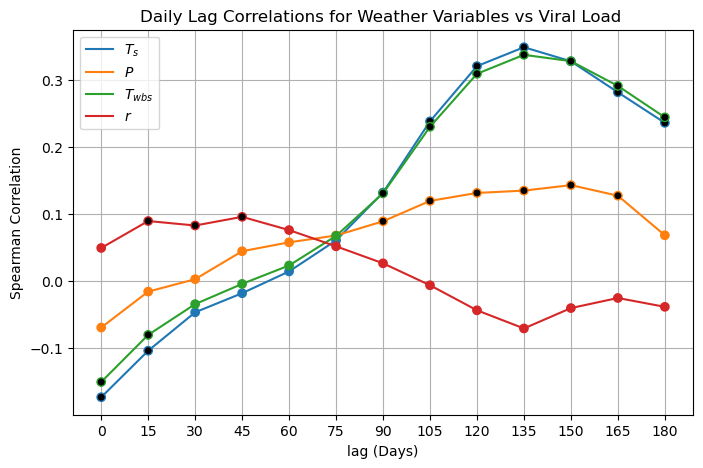

,time,twbs,tmean,hurs,ppt,tdmean,Spline_WW,Spline_PR,Spline_WW differenced,tmean_lag0,...,hurs_lag45,hurs_lag60,hurs_lag75,hurs_lag90,hurs_lag105,hurs_lag120,hurs_lag135,hurs_lag150,hurs_lag165,hurs_lag180
0,2020-01-01,4.903825,9.140190,56.148792,0.000000,0.846825,NaN,NaN,NaN,9.140190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,11.234624,13.356091,80.767583,4.966381,10.115235,NaN,NaN,NaN,13.356091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-03,14.967619,15.114837,98.920041,4.764033,14.945209,NaN,NaN,NaN,15.114837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-04,10.178196,13.313961,71.277026,0.000000,8.204920,NaN,NaN,NaN,13.313961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-05,7.844572,12.585919,55.085360,0.000000,3.798379,NaN,NaN,NaN,12.585919,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2023-12-27,7.251046,9.705548,75.925130,0.000000,5.658193,NaN,NaN,NaN,9.705548,...,93.115215,81.724344,80.920599,67.625056,55.234284,59.312967,61.516057,61.444428,65.646538,64.245032
1457,2023-12-28,6.458781,11.453634,51.207339,0.000000,1.691576,NaN,NaN,NaN,11.453634,...,86.779531,79.141644,67.271389,67.124045,63.874502,47.365507,57.843261,58.422564,62.951268,64.032252
1458,2023-12-29,4.438312,8.575075,56.564919,0.000000,0.410886,NaN,NaN,NaN,8.575075,...,90.744637,79.125932,48.982537,67.515772,80.592178,42.085005,47.354827,54.760715,61.149862,62.509914
1459,2023-12-30,3.719142,7.770247,56.479399,0.000000,-0.359127,NaN,NaN,NaN,7.770247,...,80.853196,82.157848,56.787175,64.261740,75.248760,45.265232,45.027561,58.692439,60.786355,67.592865


In [44]:
weather_vars = [TMEAN, PPT, TWBS, HURS]
covid_var = SPLINE_WW

plot_lagged_correlations_multi(df_daily_covid_weather,
                               weather_vars,
                               covid_var,
                               interval_size=15,
                               number_of_intervals=12,
                               save_path=os.path.join(FINAL_PLOTS))


## Twbs

### Twbs & Spline_WW

Cols Spline_WW, twbs
Shapiro-Wilk p-value: 1.991552806847176e-28
{'0 Days': 0, '15 Days': 15, '30 Days': 30, '45 Days': 45, '60 Days': 60, '75 Days': 75, '90 Days': 90, '105 Days': 105, '120 Days': 120, '135 Days': 135, '150 Days': 150, '165 Days': 165, '180 Days': 180}
df_merged 188 to 845
Plot saved: final_plots/twbs/daily/Daily_twbs_Spline_WW_Lagged_Correlation.png


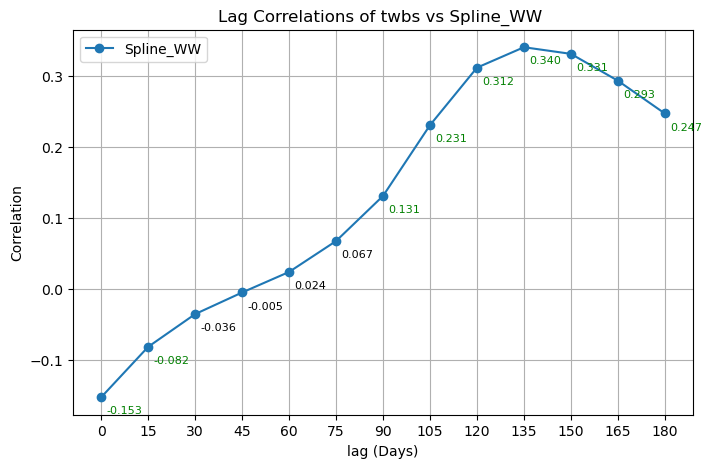

Top lags: [120, 135, 150]
Cols Spline_WW differenced, twbs
Shapiro-Wilk p-value: 1.991552806847176e-28
{'0 Days': 0, '15 Days': 15, '30 Days': 30, '45 Days': 45, '60 Days': 60, '75 Days': 75, '90 Days': 90, '105 Days': 105, '120 Days': 120, '135 Days': 135, '150 Days': 150, '165 Days': 165, '180 Days': 180}
df_merged 188 to 845
Plot saved: final_plots/twbs/daily/Daily_twbs_Spline_WW differenced_Lagged_Correlation.png


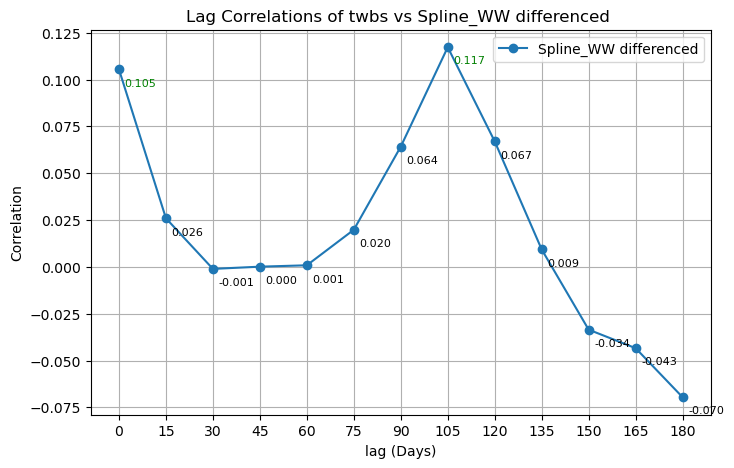

Top lags: []


In [44]:
covid_var = SPLINE_WW
weather_var = TWBS
for covid_col in [col for col in DF_DAILY_COLS if col.startswith(covid_var)]: 
    for weather_col in [col for col in DF_DAILY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_daily_covid_weather, weather_col, covid_col, interval_size=15, number_of_intervals=12, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var, DAILY))

### Twbs & Spline_PR

Cols Spline_PR, twbs
Shapiro-Wilk p-value: 1.991552806847176e-28
{'0 Days': 0, '15 Days': 15, '30 Days': 30, '45 Days': 45, '60 Days': 60, '75 Days': 75, '90 Days': 90, '105 Days': 105, '120 Days': 120, '135 Days': 135, '150 Days': 150, '165 Days': 165, '180 Days': 180}
df_merged 188 to 845
Plot saved: final_plots/twbs/daily/Daily_twbs_Spline_PR_Lagged_Correlation.png


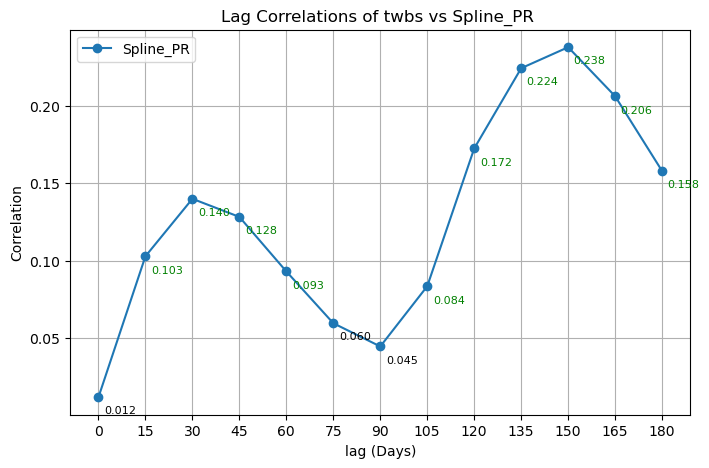

Top lags: []


In [45]:
covid_var = SPLINE_PR
weather_var = TWBS
for covid_col in [col for col in DF_DAILY_COLS if col.startswith(covid_var)]: 
    for weather_col in [col for col in DF_DAILY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_daily_covid_weather, weather_col, covid_col, interval_size=15, number_of_intervals=12, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var, DAILY))

## Tmean

### Tmean & Spline_WW

Cols Spline_WW, tmean
Shapiro-Wilk p-value: 6.631020580573286e-22
{'0 Days': 0, '15 Days': 15, '30 Days': 30, '45 Days': 45, '60 Days': 60, '75 Days': 75, '90 Days': 90, '105 Days': 105, '120 Days': 120, '135 Days': 135, '150 Days': 150, '165 Days': 165, '180 Days': 180}
df_merged 2020-01-01 00:00:00 to 2023-12-31 00:00:00
Plot saved: final_plots/tmean/daily/Daily_tmean_Spline_WW_Lagged_Correlation.png


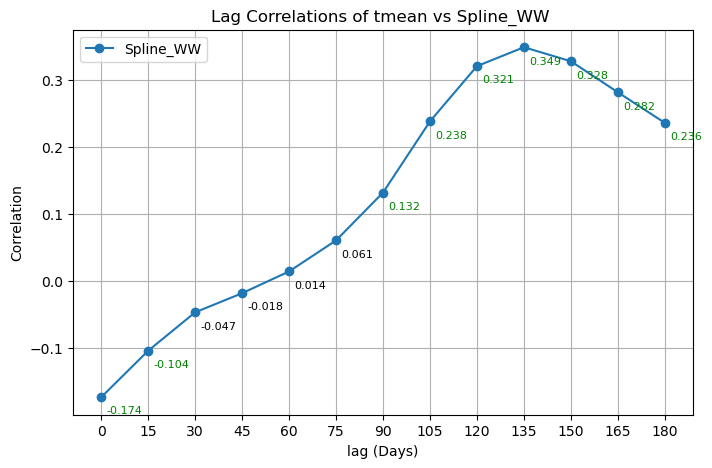

Top lags: [120, 135, 150]


,twbs,tmean,hurs,ppt,tdmean,Spline_WW,Spline_PR,Spline_WW differenced,tmean_differenced,ppt_differenced,...,tmean_lag45,tmean_lag60,tmean_lag75,tmean_lag90,tmean_lag105,tmean_lag120,tmean_lag135,tmean_lag150,tmean_lag165,tmean_lag180
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4.903825,9.140190,56.148792,0.000000,0.846825,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,11.234624,13.356091,80.767583,4.966381,10.115235,NaN,NaN,NaN,4.215901,4.966381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,14.967619,15.114837,98.920041,4.764033,14.945209,NaN,NaN,NaN,1.758746,-0.202348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,10.178196,13.313961,71.277026,0.000000,8.204920,NaN,NaN,NaN,-1.800876,-4.764033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,7.844572,12.585919,55.085360,0.000000,3.798379,NaN,NaN,NaN,-0.728042,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,7.251046,9.705548,75.925130,0.000000,5.658193,NaN,NaN,NaN,0.281242,0.000000,...,14.222560,26.686808,21.711399,28.790690,30.368691,30.484874,32.536763,30.697812,31.642380,31.107013
2023-12-28,6.458781,11.453634,51.207339,0.000000,1.691576,NaN,NaN,NaN,1.748086,0.000000,...,16.823149,26.350255,25.157166,28.930441,29.383133,29.287294,33.235978,31.723066,31.950380,31.095248
2023-12-29,4.438312,8.575075,56.564919,0.000000,0.410886,NaN,NaN,NaN,-2.878559,0.000000,...,15.719364,19.167676,18.680690,28.505214,26.841896,29.987353,32.021607,32.700863,32.083362,31.623698


In [56]:
# covid_var = SPLINE_WW
# weather_var = "tmean"
# # for covid_col in [col for col in DF_DAILY_COLS if col.startswith(covid_var)]: 
# #     for weather_col in [col for col in DF_DAILY_COLS if col.startswith(weather_var)]: 
# print(f"Cols {covid_var}, {weather_var}")
# plot_lagged_correlations(df_daily_covid_weather, weather_var, covid_var, interval_size=15, number_of_intervals=12, 
#                     save_path=os.path.join(FINAL_PLOTS, weather_var, DAILY))

Cols Spline_WW, tmean
Shapiro-Wilk p-value: 6.631020580573286e-22
{'0 Days': 0, '15 Days': 15, '30 Days': 30, '45 Days': 45, '60 Days': 60, '75 Days': 75, '90 Days': 90, '105 Days': 105, '120 Days': 120, '135 Days': 135, '150 Days': 150, '165 Days': 165, '180 Days': 180}
df_merged 188 to 845
Plot saved: final_plots/tmean/daily/Daily_tmean_Spline_WW_Lagged_Correlation.png


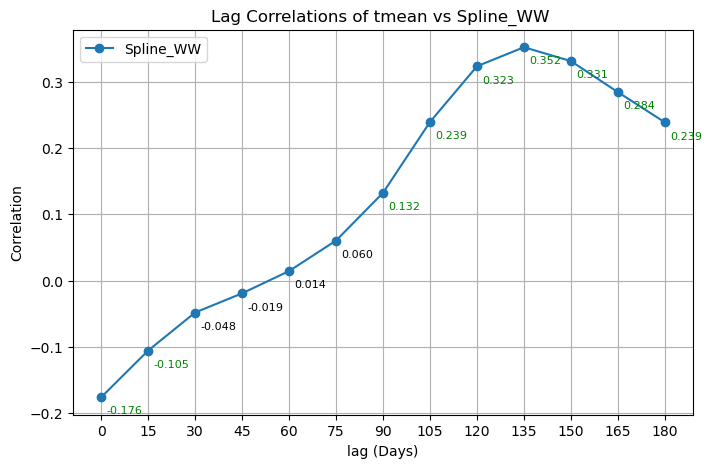

Top lags: [120, 135, 150]
Cols Spline_WW differenced, tmean
Shapiro-Wilk p-value: 6.631020580573286e-22
{'0 Days': 0, '15 Days': 15, '30 Days': 30, '45 Days': 45, '60 Days': 60, '75 Days': 75, '90 Days': 90, '105 Days': 105, '120 Days': 120, '135 Days': 135, '150 Days': 150, '165 Days': 165, '180 Days': 180}
df_merged 188 to 845
Plot saved: final_plots/tmean/daily/Daily_tmean_Spline_WW differenced_Lagged_Correlation.png


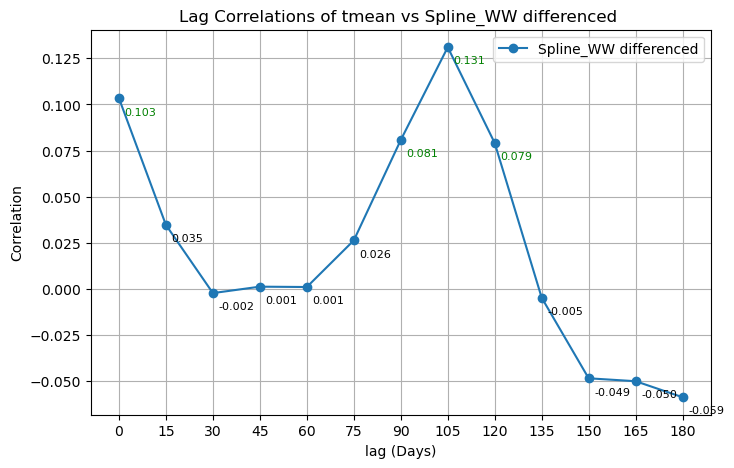

Top lags: []


In [46]:
covid_var = SPLINE_WW
weather_var = TMEAN
for covid_col in [col for col in DF_DAILY_COLS if col.startswith(covid_var)]: 
    for weather_col in [col for col in DF_DAILY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_daily_covid_weather, weather_col, covid_col, interval_size=15, number_of_intervals=12, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var, DAILY))

### Tmean & Spline_PR

Cols Spline_PR, tmean
Shapiro-Wilk p-value: 6.631020580573286e-22
{'0 Days': 0, '15 Days': 15, '30 Days': 30, '45 Days': 45, '60 Days': 60, '75 Days': 75, '90 Days': 90, '105 Days': 105, '120 Days': 120, '135 Days': 135, '150 Days': 150, '165 Days': 165, '180 Days': 180}
df_merged 188 to 845
Plot saved: final_plots/tmean/daily/Daily_tmean_Spline_PR_Lagged_Correlation.png


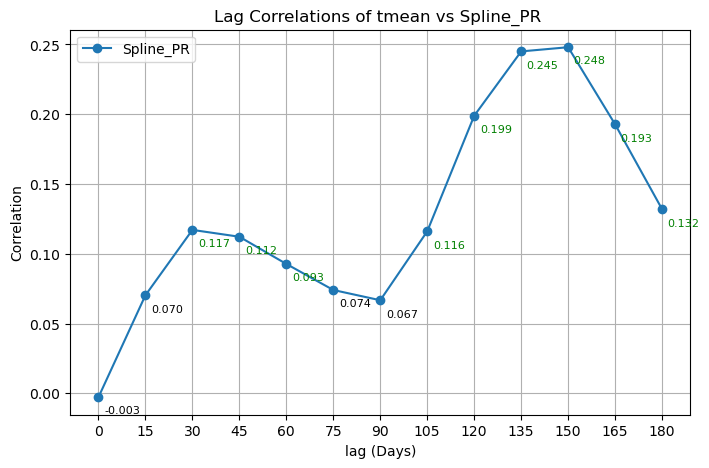

Top lags: []


In [47]:
covid_var = SPLINE_PR
weather_var = TMEAN
for covid_col in [col for col in DF_DAILY_COLS if col.startswith(covid_var)]: 
    for weather_col in [col for col in DF_DAILY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_daily_covid_weather, weather_col, covid_col, interval_size=15, number_of_intervals=12, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var, DAILY))

## Ppt

### Ppt & Spline_WW

Cols Spline_WW, ppt_differenced
Shapiro-Wilk p-value: nan
{'0 Days': 0, '15 Days': 15, '30 Days': 30, '45 Days': 45, '60 Days': 60, '75 Days': 75, '90 Days': 90, '105 Days': 105, '120 Days': 120, '135 Days': 135, '150 Days': 150, '165 Days': 165, '180 Days': 180}
df_merged 2020-01-01 00:00:00 to 2023-12-31 00:00:00
Plot saved: final_plots/ppt_differenced/daily/Daily_ppt_differenced_Spline_WW_Lagged_Correlation.png


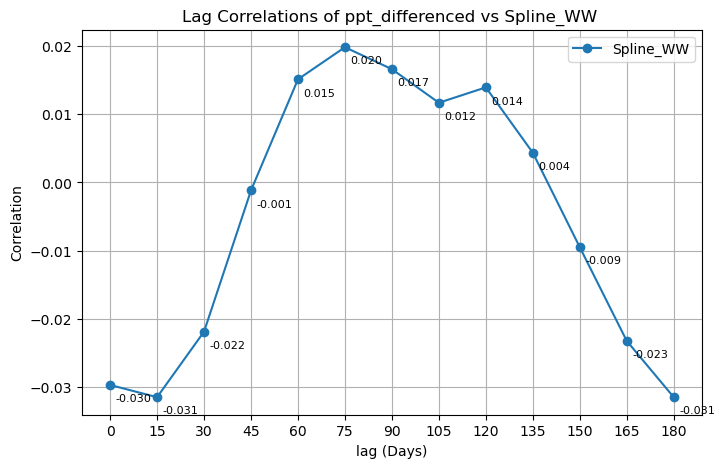

Top lags: []


,twbs,tmean,hurs,ppt,tdmean,Spline_WW,Spline_PR,Spline_WW differenced,tmean_differenced,ppt_differenced,...,ppt_differenced_lag45,ppt_differenced_lag60,ppt_differenced_lag75,ppt_differenced_lag90,ppt_differenced_lag105,ppt_differenced_lag120,ppt_differenced_lag135,ppt_differenced_lag150,ppt_differenced_lag165,ppt_differenced_lag180
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4.903825,9.140190,56.148792,0.000000,0.846825,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,11.234624,13.356091,80.767583,4.966381,10.115235,NaN,NaN,NaN,4.215901,4.966381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,14.967619,15.114837,98.920041,4.764033,14.945209,NaN,NaN,NaN,1.758746,-0.202348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,10.178196,13.313961,71.277026,0.000000,8.204920,NaN,NaN,NaN,-1.800876,-4.764033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,7.844572,12.585919,55.085360,0.000000,3.798379,NaN,NaN,NaN,-0.728042,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,7.251046,9.705548,75.925130,0.000000,5.658193,NaN,NaN,NaN,0.281242,0.000000,...,-6.910960,-19.101468,-3.973606,0.302267,0.000000,-1.430555,0.000000,-0.413608,0.0,0.000000
2023-12-28,6.458781,11.453634,51.207339,0.000000,1.691576,NaN,NaN,NaN,1.748086,0.000000,...,13.608550,-0.738632,0.000107,-1.180776,3.833847,-0.001517,0.000000,-0.000021,0.0,0.000000
2023-12-29,4.438312,8.575075,56.564919,0.000000,0.410886,NaN,NaN,NaN,-2.878559,0.000000,...,-2.673533,0.149074,-0.000162,-0.312761,14.559124,0.000000,0.000557,0.000000,0.0,0.455731


In [58]:
covid_var = SPLINE_WW
weather_var = "ppt_differenced"
# for covid_col in [col for col in DF_DAILY_COLS if col.startswith(covid_var)]: 
#     for weather_col in [col for col in DF_DAILY_COLS if col.startswith(weather_var)]: 
print(f"Cols {covid_var}, {weather_var}")
plot_lagged_correlations(df_daily_covid_weather, weather_var, covid_var, interval_size=15, number_of_intervals=12, 
                    save_path=os.path.join(FINAL_PLOTS, weather_var, DAILY))

Cols Spline_WW, ppt
Shapiro-Wilk p-value: 3.6716813316999714e-55
{'0 Days': 0, '15 Days': 15, '30 Days': 30, '45 Days': 45, '60 Days': 60, '75 Days': 75, '90 Days': 90, '105 Days': 105, '120 Days': 120, '135 Days': 135, '150 Days': 150, '165 Days': 165, '180 Days': 180}
df_merged 188 to 845
Plot saved: final_plots/ppt/daily/Daily_ppt_Spline_WW_Lagged_Correlation.png


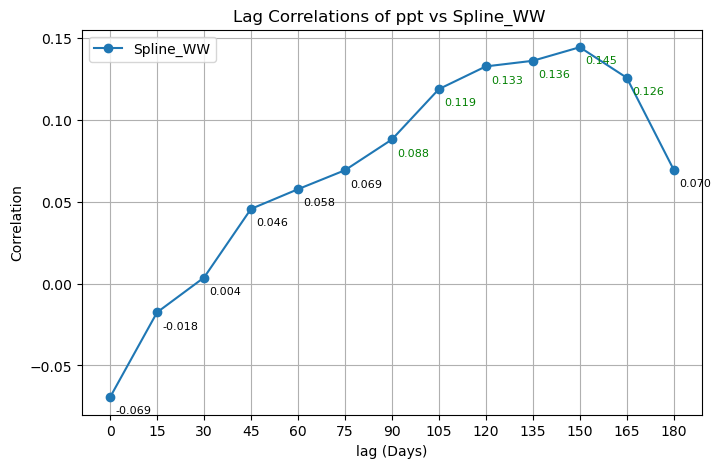

Top lags: []
Cols Spline_WW differenced, ppt
Shapiro-Wilk p-value: 3.6716813316999714e-55
{'0 Days': 0, '15 Days': 15, '30 Days': 30, '45 Days': 45, '60 Days': 60, '75 Days': 75, '90 Days': 90, '105 Days': 105, '120 Days': 120, '135 Days': 135, '150 Days': 150, '165 Days': 165, '180 Days': 180}
df_merged 188 to 845
Plot saved: final_plots/ppt/daily/Daily_ppt_Spline_WW differenced_Lagged_Correlation.png


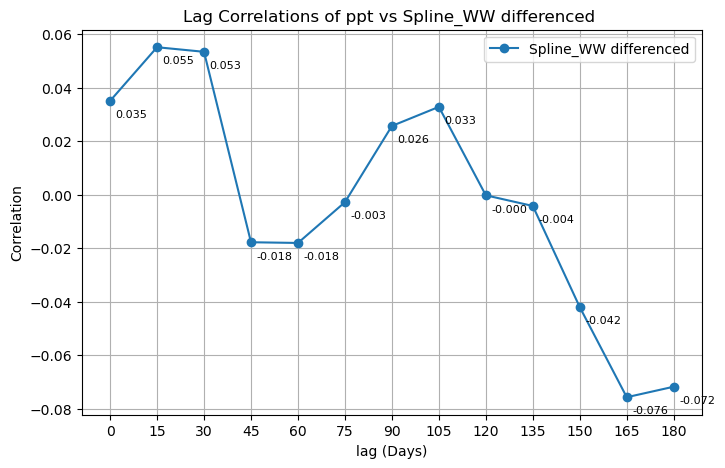

Top lags: []


In [48]:
covid_var = SPLINE_WW
weather_var = PPT
for covid_col in [col for col in DF_DAILY_COLS if col.startswith(covid_var)]: 
    for weather_col in [col for col in DF_DAILY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_daily_covid_weather, weather_col, covid_col, interval_size=15, number_of_intervals=12, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var, DAILY))

### Ppt & Spline_PR

Cols Spline_PR, ppt
Shapiro-Wilk p-value: 3.6716813316999714e-55
{'0 Days': 0, '15 Days': 15, '30 Days': 30, '45 Days': 45, '60 Days': 60, '75 Days': 75, '90 Days': 90, '105 Days': 105, '120 Days': 120, '135 Days': 135, '150 Days': 150, '165 Days': 165, '180 Days': 180}
df_merged 188 to 845
Plot saved: final_plots/ppt/daily/Daily_ppt_Spline_PR_Lagged_Correlation.png


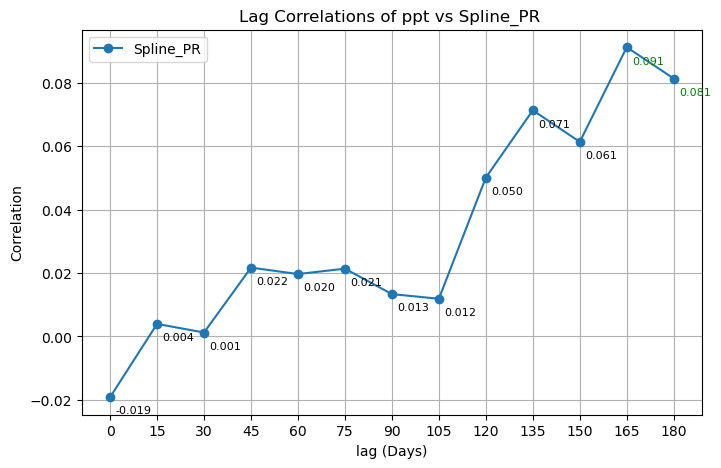

Top lags: []


In [49]:
covid_var = SPLINE_PR
weather_var = PPT
for covid_col in [col for col in DF_DAILY_COLS if col.startswith(covid_var)]: 
    for weather_col in [col for col in DF_DAILY_COLS if col.startswith(weather_var)]: 
        print(f"Cols {covid_col}, {weather_col}")
        plot_lagged_correlations(df_daily_covid_weather, weather_col, covid_col, interval_size=15, number_of_intervals=12, 
                                save_path=os.path.join(FINAL_PLOTS, weather_var, DAILY))

In [50]:
plot_lagged_correlations(df_covid_weather_vars, 'twbs', 'Spline_WW', interval_size=15, number_of_intervals=12)
plot_lagged_correlations(df_covid_weather_vars, 'twbs', 'Spline_PR', interval_size=15, number_of_intervals=12)

NameError: name 'df_covid_weather_vars' is not defined

## Old Correlation Code

In [ ]:
plot_lagged_correlations(df_covid_weather_vars, 'ppt', 'Spline_WW', interval_size=10, number_of_intervals=15)
plot_lagged_correlations(df_covid_weather_vars, 'ppt', 'Spline_PR', interval_size=10, number_of_intervals=15)

In [ ]:
plot_lagged_correlations(df_covid_weather_vars, 'tmean', 'Spline_WW', interval_size=15, number_of_intervals=12)
plot_lagged_correlations(df_covid_weather_vars, 'tmean', 'Spline_PR', interval_size=15, number_of_intervals=12)

In [ ]:
plot_lagged_correlations(df_covid_weather_vars, 'tdmean', 'Spline_WW', interval_size=15, number_of_intervals=12)
plot_lagged_correlations(df_covid_weather_vars, 'tdmean', 'Spline_PR', interval_size=15, number_of_intervals=12)

# Prewhiten data

## Constants

In [20]:
import os 
import xarray as xr 
import numpy as np 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [21]:
def weighted_mean(ds, lat_name, lon_name): 
    lats = ds[lat_name]
    weights = np.cos(np.deg2rad(lats)) 
    weights.name = "weights"

    ds_weighted = ds.weighted(weights) 
    ds_weighted_mean = ds_weighted.mean([lon_name, lat_name]) 

    return ds_weighted_mean 

In [24]:
# Go through each variable and create nc file for 2020-2025
for i, var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        files.append(os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}.nc')) 
        
    # ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested').load()

    ds = xr.open_mfdataset(
            files,
            concat_dim='time',
            combine='nested',
            engine='netcdf4'  # optional but safer
        ).load()

    if 'time' in ds.sizes and ds.sizes['time'] == 366:
        ds = ds.transpose('time', 'lat', 'lon')
    
    # Get mean 
    ds_mean = weighted_mean(ds, 'lat', 'lon')

    outfile_path = os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{years[0]}_{years[-1]}.nc') 

    ds_mean.to_netcdf(outfile_path)
    print(f"Saved file at {outfile_path}")

NameError: name 'variables' is not defined

## Differencing

In [14]:
# df_daily_covid_weather["Spline_WW_Differenced"] = df_daily_covid_weather["Spline_WW"].diff(1).dropna()

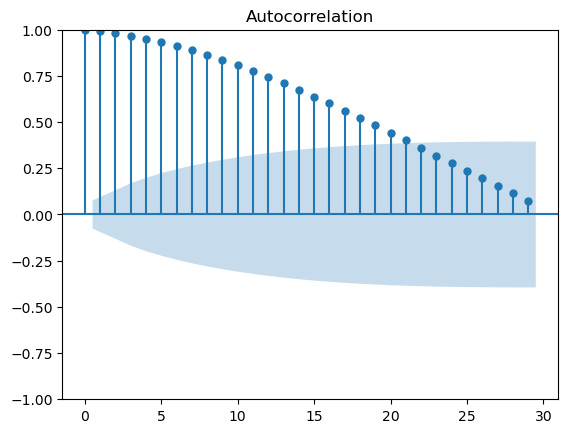

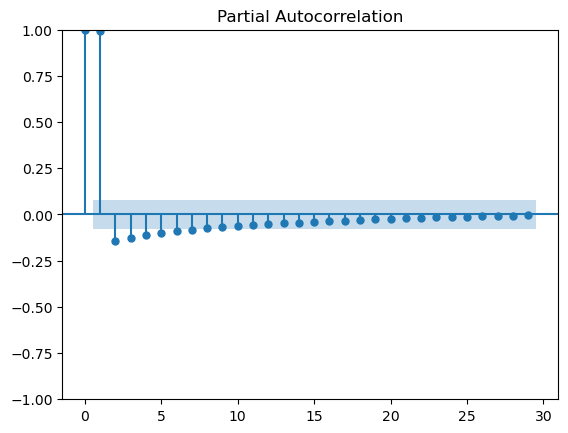

In [26]:
# Compute differenced series
df_daily_covid_weather["Spline_WW_Differenced"] = df_daily_covid_weather["Spline_WW"].diff()

# Plot ACF of the differenced series
plot_acf(df_daily_covid_weather["Spline_WW_Differenced"].dropna())
plt.show()

plot_pacf(df_daily_covid_weather["Spline_WW_Differenced"].dropna())
plt.show()

## Using AutoRegression Residuals

### Removing Mean & Autocorrelation (AutoReg - Residuals)

In [40]:
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acovf
from scipy.linalg import toeplitz

var = 'Spline_WW'
# print(home)
# home = home +  "/wastewater"
# Harris_County_PRISM_weighted_mean_twbs_stable_4kmD2_2020_2023
file_path = os.path.join(home, f'Harris_County_PRISM_weighted_mean_{var}_stable_4km{daily}_{years[0]}_2023.nc') 

print(f"Removing autocorrelation using AR(1) for var {var} ({file_path})")

# Open file and get values 
ds = xr.open_dataset(file_path)
da = ds[var]  
ts = da.values

# Plot time series 
plt.plot(da.time, ts) 
plt.title(f"Time series of {var} before whitening")
plt.xticks(rotation=45)
plt.show()

plot_acf(ts)
plt.title(f"{var} ACF before whitening")
plt.savefig(f'plots/ACF_{var}')
plt.show()

plot_pacf(ts)
plt.title(f"{var} PACF before whitening")
plt.show()

# Fit AR model
lags=1
model = AutoReg(ts, lags=lags) 
fit = model.fit()

# Get residuals
whitened_ts = fit.resid

print(whitened_ts)
# Saving
file_path = os.path.join(home, var, 'netcdf' , f'Harris_County_PRISM_{var}_stable_4km{daily}_{years[0]}_{years[-1]}_whitened_AR_{lags}.nc') 

if os.path.exists(file_path): 
    os.remove(file_path)
    
da_whitened = xr.DataArray(
    data=whitened_ts,
    coords={"time": da.time[lags:]},
    dims="time",
    name=f"whitened_{var}_AR({lags})"
)

# Save to NetCDF
da_whitened.to_netcdf(file_path)
print(f"Saved whitened array at {file_path}")
print(max(da.time), min(da.time))


plt.plot(da.time[lags:], whitened_ts) 
plt.title(f"Time series of {var} after whitening AR({lags})")
plt.xticks(rotation=45)
plt.show()

# # Plot ACF of whitened series 
plot_acf(whitened_ts)
plt.title(f"{var} ACF after whitening AR({lags})")
plt.savefig(f'plots/ACF_{var}_AR({lags})')
print(f'saved at plots/ACF_{var}_AR({lags})')
plt.show()

plot_pacf(whitened_ts)
plt.title(f"{var} PACF after whitening AR({lags})")
plt.show()

Removing autocorrelation using AR(1) for var Spline_WW (/home/sd96/rdf/Harris_County_PRISM_weighted_mean_Spline_WW_stable_4kmD2_2020_2023.nc)


FileNotFoundError: [Errno 2] No such file or directory: '/home/sd96/rdf/Harris_County_PRISM_weighted_mean_Spline_WW_stable_4kmD2_2020_2023.nc'

In [41]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

var_dict = {'ppt': 'Precipitation', 'tmean': 'Temperature', 'Spline_WW': 'Viral Load', 'Spline_PR': 'Positivity Rate'}
def whiten_with_autoreg(series, var, lag, plot=True):
    """
    Apply AutoReg to a pandas Series and return the residuals (whitened series).
    """
    # Drop NaNs to fit the model
    valid = series[var].dropna()

    if plot: 
        plot_acf(valid)
        plt.title(f"ACF plot of {var_dict[var]}")
        plt.savefig(f'plots/ACF_{var}')
        print(f'saved at plots/ACF_{var}')
        plt.show()
        
        plot_pacf(valid)
        plt.title(f"PACF plot of {var_dict[var]}")
        plt.savefig(f'plots/PACF_{var}')
        plt.show()

    # Fit AutoReg model
    model = AutoReg(valid, lags=lag, old_names=False)
    model_fit = model.fit()
    
    # Get residuals (whitened signal)
    residuals = model_fit.resid

    if plot: 
        # # Plot ACF of whitened series 
        plot_acf(residuals)
        plt.title(f"ACF plot of {var_dict[var]} AR({lag}) Residuals")
        plt.savefig(f'plots/ACF_{var}_AR({lag})')
        print(f'saved at plots/ACF_{var}_AR({lag})')
        plt.show()
        
        plot_pacf(residuals)
        plt.title(f"PACF plot of {var_dict[var]} AR({lag}) Residuals")
        plt.savefig(f'plots/PACF_{var}_AR({lag})')
        plt.show()

    # print(var, "BIC", model_fit.bic)
    # print(var, "AIC", model_fit.aic)
    return residuals.reindex(series.index), model_fit.bic, model_fit.aic

### Constants & Data

In [42]:
import pandas as pd
import os
import xarray as xr
from collections import defaultdict
home = '/home/sd96/rdf'
variables = ['tmean'] 

years = ['2020', '2021', '2022', '2023'] 
daily = "D2"

# SET BEFORE USE
weather_lag = 7
covid_lag = 5
covid_var = "Spline_WW"
var = 'tmean'
TEST_VAR = True 
TEST_COVID = True
# WEATHER: Load file
weather_file_path = os.path.join(home, f'Harris_County_PRISM_weighted_mean_{var}_stable_4km{daily}_{years[0]}_{years[-1]}.nc') 
# WEATHER: Convert to Dataframe
ds = xr.open_dataset(weather_file_path)
df_var = ds.to_dataframe()

# COVID: Load and create covid df
df_covid_full = pd.read_csv(
   os.path.join(home, "sarscov2ww_ricehhd.csv")
)

df_covid_full.rename(columns={'date': 'Date'}, inplace=True)
df_covid_full['Date'] = pd.to_datetime(df_covid_full['Date'])

# COVID: Save total Column and drop the column name
df_covid = df_covid_full[df_covid_full['WWTP'] == 'TOTAL']
df_covid = df_covid[['Date', 'Spline_WW', 'Spline_PR']]


df_covid.set_index('Date', inplace=True)
df_covid.index = pd.to_datetime(df_covid.index)

/tmp/ipykernel_29129/939094918.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_covid_full['Date'] = pd.to_datetime(df_covid_full['Date'])


saved at plots/ACF_Spline_WW


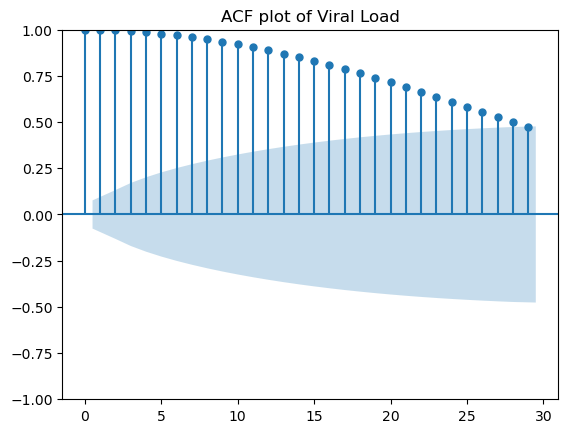

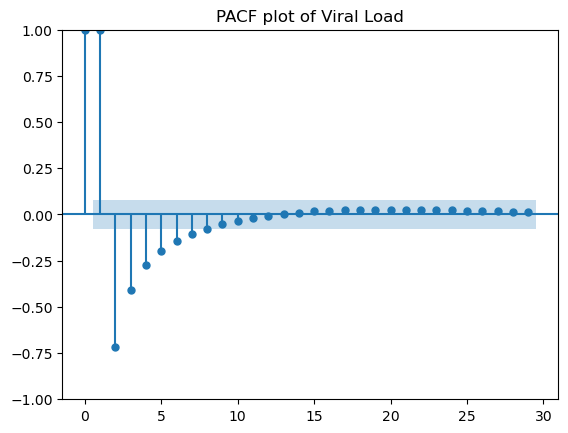

saved at plots/ACF_Spline_WW_AR(1)


/home/sd96/miniforge3/envs/conda_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


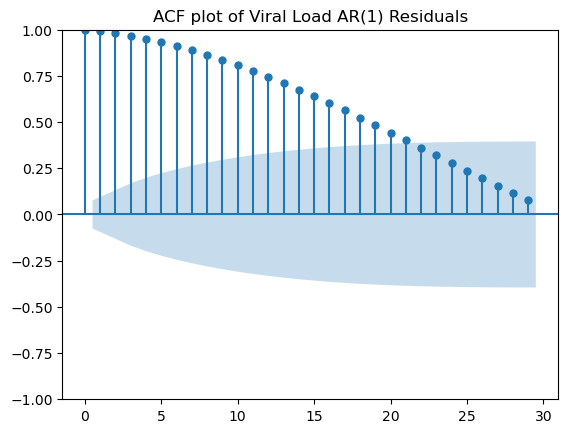

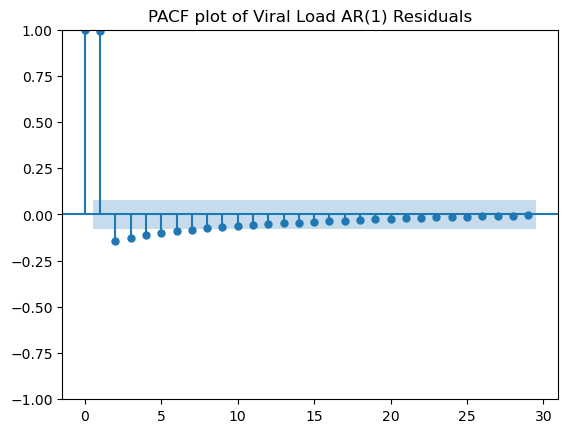

In [44]:
whitened_weather_series, bic, aic = whiten_with_autoreg(df_covid, "Spline_WW", lag=1, plot=True)

p=0: BIC=10539.64, AIC=10529.06
p=1: BIC=10432.19, AIC=10416.33
p=2: BIC=10430.52, AIC=10409.37
p=3: BIC=10431.03, AIC=10404.60
p=4: BIC=10431.59, AIC=10399.88
p=5: BIC=10432.57, AIC=10395.59
p=6: BIC=10433.47, AIC=10391.21
p=7: BIC=10434.41, AIC=10386.87
Best p (lowest BIC) = 2 | BIC=10430.52, AIC=10409.37
saved at plots/ACF_ppt


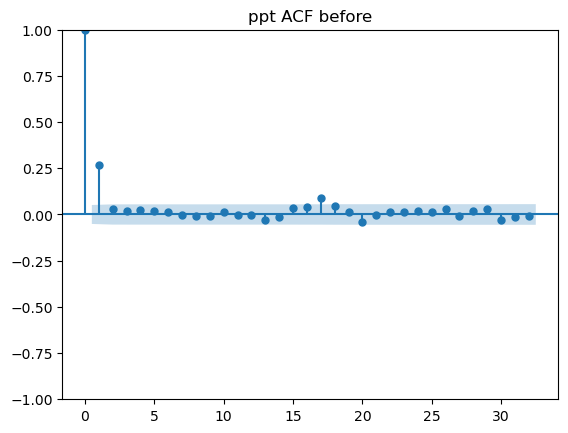

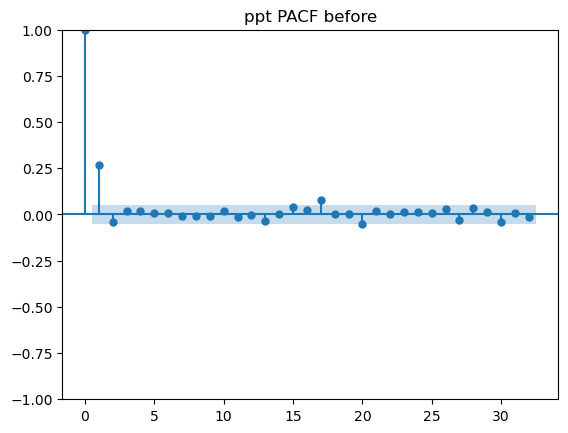

saved at plots/ACF_ppt_AR(2)


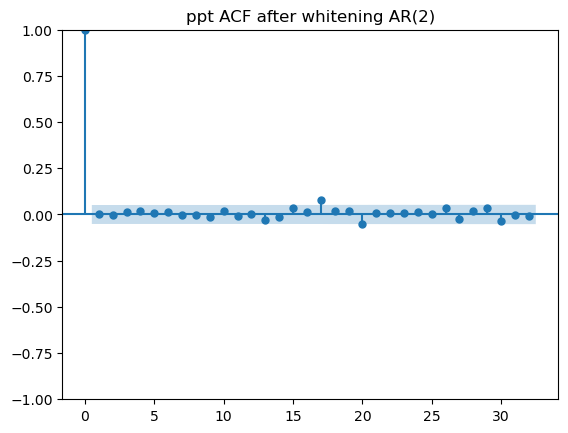

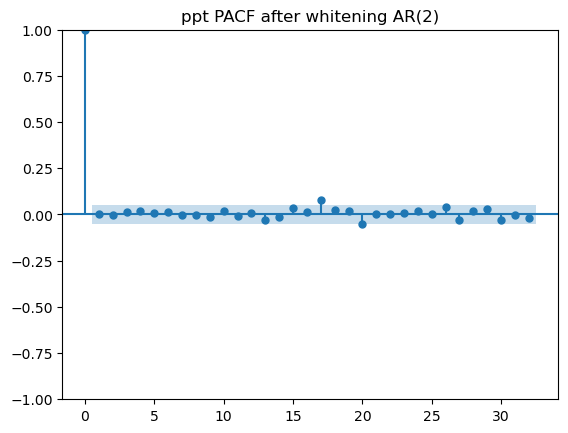

In [109]:
if TEST_VAR:
    results = defaultdict(int) 
    for p in range(8): 
        whitened_weather_series, bic, aic = whiten_with_autoreg(df_var, f'{var}', lag=p, plot=False)
        results[p] = (whitened_weather_series, bic, aic) 

    for p, (series, bic, aic) in results.items():
        print(f"p={p}: BIC={bic:.2f}, AIC={aic:.2f}")
        
    min_bic_p = min(results.items(), key=lambda item: item[1][1])
    best_p = min_bic_p[0]
    best_series, best_bic, best_aic = min_bic_p[1]
    print(f"Best p (lowest BIC) = {best_p} | BIC={best_bic:.2f}, AIC={best_aic:.2f}")

    whitened_weather_series, bic, aic = whiten_with_autoreg(df_var, f'{var}', lag=best_p, plot=True)
    

Testing Values for Spline_WW
p=0: BIC=734.73, AIC=725.74
p=1: BIC=-3461.00, AIC=-3474.47
p=2: BIC=-7768.30, AIC=-7786.26
p=3: BIC=-10910.00, AIC=-10932.43
p=4: BIC=-12763.83, AIC=-12790.74
p=5: BIC=-12979.94, AIC=-13011.33
p=6: BIC=-13026.34, AIC=-13062.19
p=7: BIC=-13023.68, AIC=-13064.00
p=8: BIC=-13006.24, AIC=-13051.02
p=9: BIC=-12982.06, AIC=-13031.30
Best p (lowest BIC) = 6 | BIC=-13026.34, AIC=-13062.19
saved at plots/ACF_Spline_WW


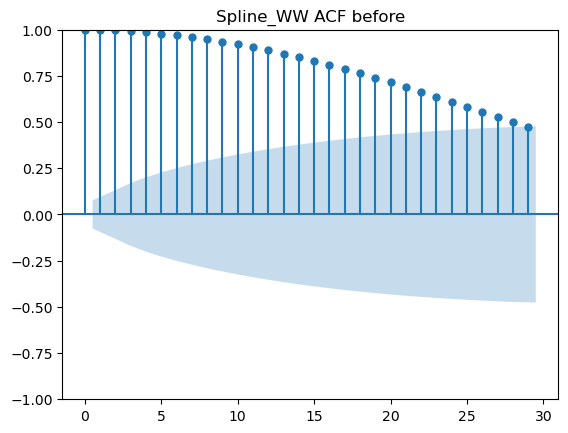

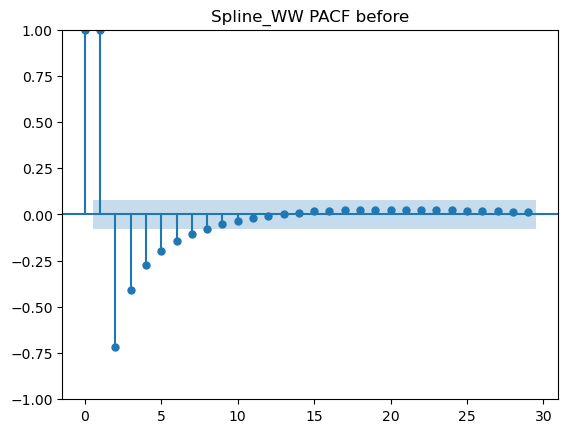

saved at plots/ACF_Spline_WW_AR(6)


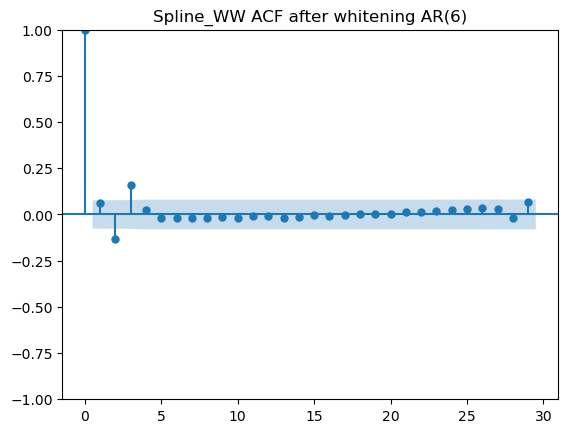

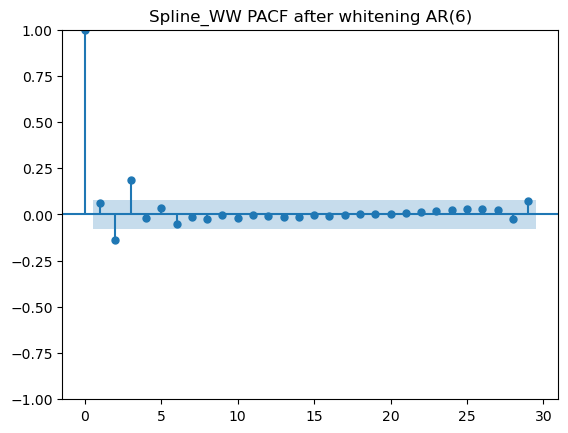

In [87]:

print("Testing Values for", covid_var)
results = defaultdict(int) 
for p in range(10): 
    whitened_covid_series, bic, aic = whiten_with_autoreg(df_covid, f'{covid_var}', lag=p, plot=False)
    results[p] = (whitened_covid_series, bic, aic) 

for p, (series, bic, aic) in results.items():
    print(f"p={p}: BIC={bic:.2f}, AIC={aic:.2f}")

min_bic_p = min(results.items(), key=lambda item: item[1][1])
best_p = min_bic_p[0]
best_series, best_bic, best_aic = min_bic_p[1]
print(f"Best p (lowest BIC) = {best_p} | BIC={best_bic:.2f}, AIC={best_aic:.2f}")

whitened_covid_series, bic, aic = whiten_with_autoreg(df_covid, f'{covid_var}', lag=best_p, plot=True)


### Removing AutoCorrelation

TMEAN
tmean: 2020-01-01 00:00:00 to 2023-12-31 00:00:00
Index(['tmean'], dtype='object')
saved at plots/ACF_tmean


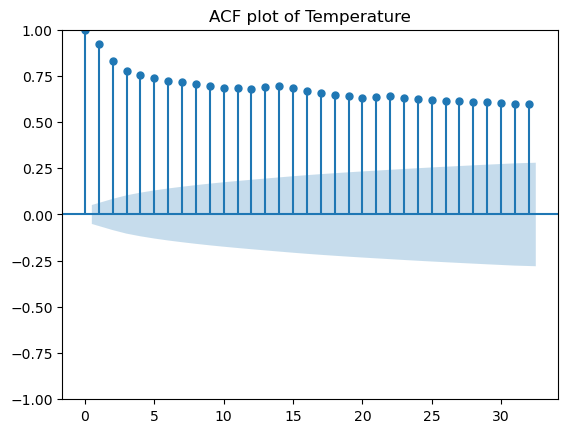

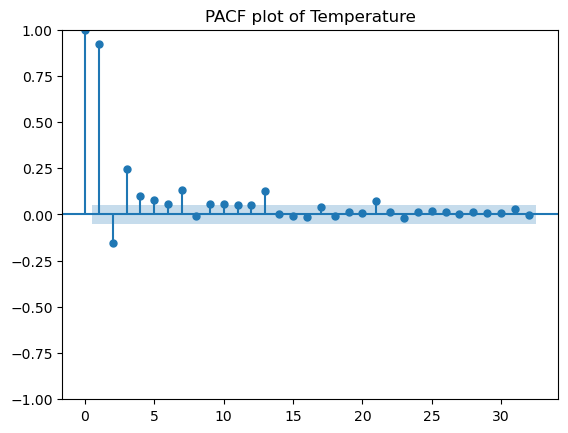

saved at plots/ACF_tmean_AR(7)


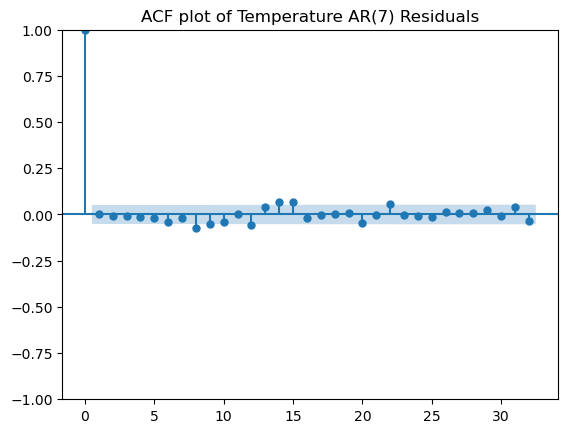

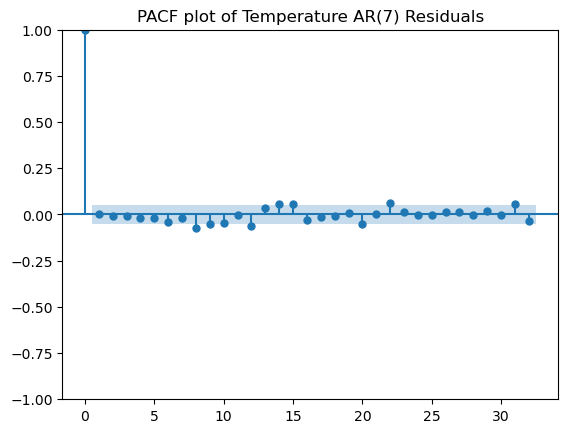

Saved whitened array at /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmD2_2020_2023_whitened_AR_7.nc
<xarray.DataArray 'time' ()> Size: 8B
array('2023-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2023-12-31 <xarray.DataArray 'time' ()> Size: 8B
array('2020-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-01-01
saved at plots/ACF_Spline_WW


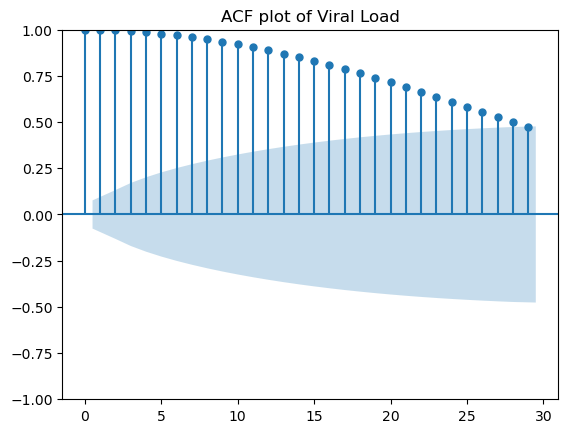

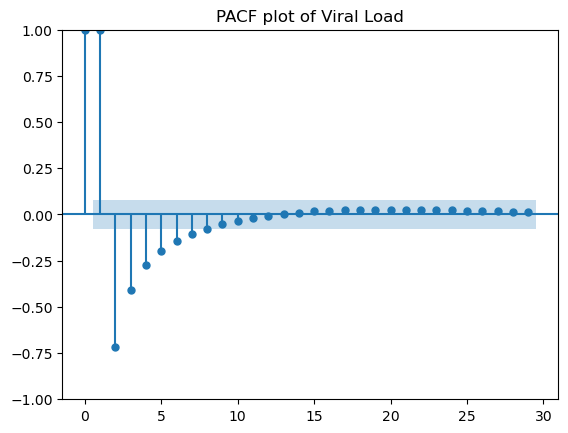

saved at plots/ACF_Spline_WW_AR(5)


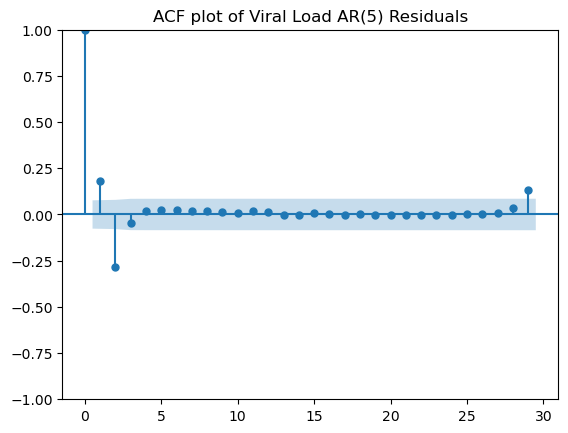

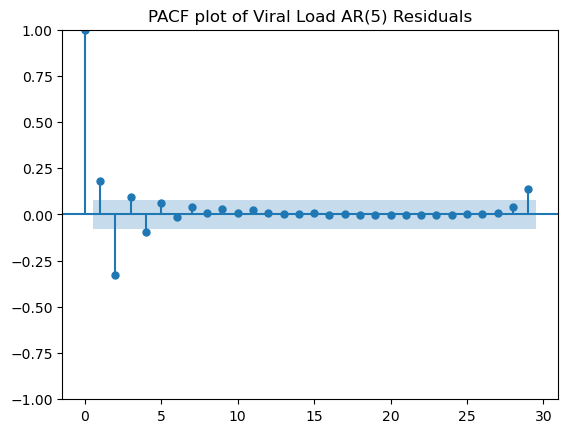

Saved whitened array at /home/sd96/rdf/covid/netcdf/Spline_WW_daily_2020_2023_whitened_AR_5.nc
tmean min 2020-01-01 00:00:00 max 2023-12-31 00:00:00
Spline_WW min 2020-07-06 00:00:00 max 2022-04-25 00:00:00
df_var_covid 2020-07-06 00:00:00 to 2022-04-25 00:00:00
Index(['Spline_WW', 'Spline_PR', 'Spline_WW_whitened_AR_5', 'tmean',
       'tmean_whitened_AR_7'],
      dtype='object')


In [56]:
weather_file_path = os.path.join(home, var, 'netcdf' , f'Harris_County_PRISM_{var}_stable_4km{daily}_{years[0]}_{years[-1]}.nc') 

# WEATHER: Convert to Dataframe
ds = xr.open_dataset(weather_file_path)
df_var = ds.to_dataframe()

print(f"{var.upper()}")
print(f"{var}:", df_var.index.min(), "to", df_var.index.max())
print(df_var.columns)

# WEATHER: WHITEN DATA

whitened_weather_series, bic, aic = whiten_with_autoreg(df_var, f'{var}', lag=weather_lag)
col_name = f"{var}_whitened_AR_{weather_lag}"

# WEATHER: Save to DF 
df_var[col_name] = whitened_weather_series

# WEATHER: Save as nc file
da_whitened = xr.DataArray(
    whitened_weather_series,
    coords={"time": df_var.index},
    dims=["time"],
    name=col_name
)

file_path = os.path.join(
    home, var, 'netcdf', f"Harris_County_PRISM_{var}_stable_4km{daily}_{years[0]}_{years[-1]}_whitened_AR_{weather_lag}.nc"
)

da_whitened.to_netcdf(file_path)
print(f"Saved whitened array at {file_path}")
print(max(da_whitened.time), min(da_whitened.time))


# COVID: WHITEN DATA
whitened_covid_series, bic, aic = whiten_with_autoreg(df_covid, covid_var, lag=covid_lag)

col_name = f'{covid_var}_whitened_AR_{covid_lag}'
df_covid[col_name] = whitened_covid_series

# Create xarray DataArray
da_whitened = xr.DataArray(
    whitened_covid_series,
    coords={"Date": df_covid.index},  # use coords, not coord
    dims=["Date"],                     # dims should be a list
    name=col_name
)

# Save to NetCDF
path = os.path.join(home, "covid", 'netcdf', f'{covid_var}_daily_{years[0]}_{years[-1]}_whitened_AR_{covid_lag}.nc')
da_whitened.to_netcdf(path)
print(f"Saved whitened array at {path}")



print(var, "min", df_var.index.min(), "max", df_var.index.max())
print(covid_var, "min", df_covid.index.min(), "max", df_covid.index.max())

# BOTH: Join covid and weather df 
# df_var_covid = df_var_covid.join(df_covid, how='left')
df_var_covid = df_covid.join(df_var, how='left')


print("df_var_covid", df_var_covid.index.min(), "to", df_var_covid.index.max())
print(df_var_covid.columns)

Shapiro-Wilk p-value: 1.883045429889445e-14
{'0 days': 0, '15 days': 15, '30 days': 30, '45 days': 45, '60 days': 60, '75 days': 75, '90 days': 90, '105 days': 105, '120 days': 120, '135 days': 135, '150 days': 150, '165 days': 165, '180 days': 180, '195 days': 195, '210 days': 210, '225 days': 225}
df_merged 2021-02-16 00:00:00 to 2022-04-25 00:00:00
Index(['Spline_WW', 'Spline_PR', 'Spline_WW_whitened_AR_5', 'tmean',
       'tmean_whitened_AR_7', 'tmean_lag0', 'tmean_lag15', 'tmean_lag30',
       'tmean_lag45', 'tmean_lag60', 'tmean_lag75', 'tmean_lag90',
       'tmean_lag105', 'tmean_lag120', 'tmean_lag135', 'tmean_lag150',
       'tmean_lag165', 'tmean_lag180', 'tmean_lag195', 'tmean_lag210',
       'tmean_lag225'],
      dtype='object')
Lag 0 days:
  Spline_WW: r = 0.186, p = 0.000
Lag 15 days:
  Spline_WW: r = 0.329, p = 0.000
Lag 30 days:
  Spline_WW: r = 0.409, p = 0.000
Lag 45 days:
  Spline_WW: r = 0.417, p = 0.000
Lag 60 days:
  Spline_WW: r = 0.422, p = 0.000
Lag 75 days:
 

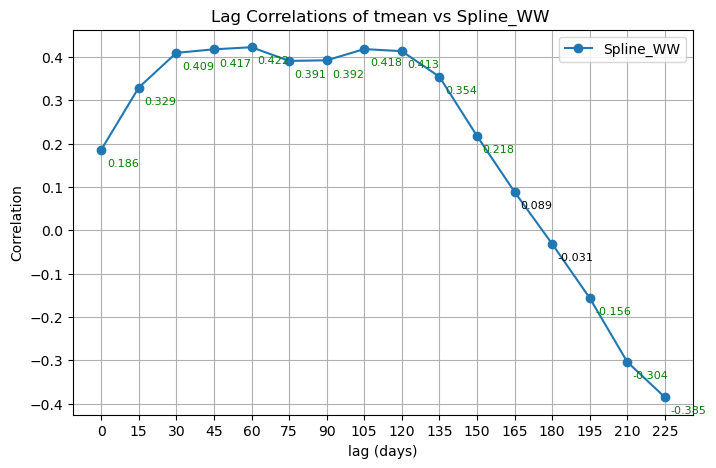

Top lags: [15, 30, 45, 60, 75, 90, 105, 120, 135, 210, 225]
Shapiro-Wilk p-value: 1.0990940209071059e-16
{'0 days': 0, '15 days': 15, '30 days': 30, '45 days': 45, '60 days': 60, '75 days': 75, '90 days': 90, '105 days': 105, '120 days': 120, '135 days': 135, '150 days': 150, '165 days': 165, '180 days': 180, '195 days': 195, '210 days': 210, '225 days': 225}
df_merged 2021-02-16 00:00:00 to 2022-04-25 00:00:00
Index(['Spline_WW', 'Spline_PR', 'Spline_WW_whitened_AR_5', 'tmean',
       'tmean_whitened_AR_7', 'tmean_whitened_AR_7_lag0',
       'tmean_whitened_AR_7_lag15', 'tmean_whitened_AR_7_lag30',
       'tmean_whitened_AR_7_lag45', 'tmean_whitened_AR_7_lag60',
       'tmean_whitened_AR_7_lag75', 'tmean_whitened_AR_7_lag90',
       'tmean_whitened_AR_7_lag105', 'tmean_whitened_AR_7_lag120',
       'tmean_whitened_AR_7_lag135', 'tmean_whitened_AR_7_lag150',
       'tmean_whitened_AR_7_lag165', 'tmean_whitened_AR_7_lag180',
       'tmean_whitened_AR_7_lag195', 'tmean_whitened_AR_7_lag2

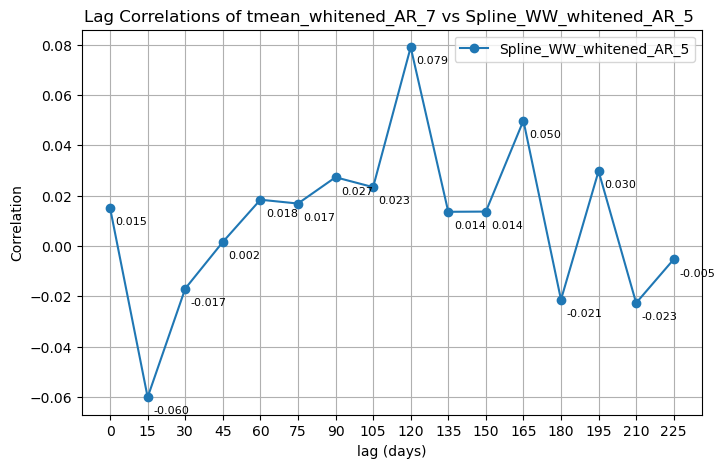

Top lags: []


,Spline_WW,Spline_PR,Spline_WW_whitened_AR_5,tmean,tmean_whitened_AR_7,tmean_whitened_AR_7_lag0,tmean_whitened_AR_7_lag15,tmean_whitened_AR_7_lag30,tmean_whitened_AR_7_lag45,tmean_whitened_AR_7_lag60,...,tmean_whitened_AR_7_lag90,tmean_whitened_AR_7_lag105,tmean_whitened_AR_7_lag120,tmean_whitened_AR_7_lag135,tmean_whitened_AR_7_lag150,tmean_whitened_AR_7_lag165,tmean_whitened_AR_7_lag180,tmean_whitened_AR_7_lag195,tmean_whitened_AR_7_lag210,tmean_whitened_AR_7_lag225
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-16,13.605008,0.114007,4.414789e-07,-7.559888,-5.901914,-5.901914,-7.813079,0.590870,-2.678672,0.434689,...,-1.319180,-2.363785,0.715836,1.199562,-0.595648,-1.475254,-1.222651,0.752280,-1.611286,0.305915
2021-02-17,13.595747,0.111396,4.881514e-07,-4.304870,-0.723097,-0.723097,0.709077,2.103414,-0.615511,1.413356,...,-0.847102,0.854916,0.106219,-0.267233,-2.127186,-0.386849,0.313368,0.815874,0.199344,0.292298
2021-02-18,13.586673,0.110904,2.580626e-07,1.065737,0.762083,0.762083,-1.462521,0.391251,0.831971,1.765425,...,1.447750,1.586400,1.090541,0.214645,-2.789727,-0.565821,0.233176,0.442102,0.718447,0.654907
2021-02-19,13.577809,0.114376,2.998584e-07,-0.012764,-3.097135,-3.097135,1.457216,6.829303,1.966586,-1.905920,...,2.394159,2.367362,0.916103,0.374212,0.437924,0.198613,-1.373129,0.320160,1.321056,0.864547
2021-02-20,13.569179,0.116054,1.618175e-06,2.886171,3.330049,3.330049,3.681469,-2.495457,-1.517546,2.874241,...,-1.035798,-0.206085,0.267347,1.164055,0.067187,-0.362352,1.575723,0.619790,-0.349775,0.007153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-21,13.416142,0.045910,7.914340e-06,24.901172,4.897103,4.897103,3.943774,4.093894,-1.499539,2.883881,...,-9.637973,3.440155,-1.804684,-2.287172,0.896755,-0.951707,0.858572,-0.067062,-5.657360,-0.162966
2022-04-22,13.447710,0.046127,7.580583e-06,25.512130,-0.454673,-0.454673,-6.716012,-6.070959,-6.773844,2.243028,...,0.832130,-6.147477,1.887658,-2.878471,-5.655300,0.294645,0.227269,0.145260,0.871276,0.304417
2022-04-23,13.480710,0.047806,7.348529e-06,24.835808,0.618416,0.618416,-0.528833,0.895524,-3.733493,7.949237,...,-2.365806,-2.064609,2.460047,2.557777,1.184903,1.684576,3.075303,0.512523,-1.374427,-0.391081


In [57]:
int_size = 15
num_ints = 15
plot_lagged_correlations(df_var_covid, f'{var}', f'{covid_var}', 
                         interval_size=int_size, number_of_intervals=num_ints)
plot_lagged_correlations(df_var_covid, f'{var}_whitened_AR_{weather_lag}', f'{covid_var}_whitened_AR_{covid_lag}', 
                         interval_size=int_size, number_of_intervals=num_ints)

### Plotting ACF, PACF 

In [13]:
def plot_acf_pacf(ts, var, save=True): 
    # var_label = labels.get(ds.name, ds.name) if labels else da.name

    fig, axes = plt.subplots(2, 1, figsize=(12, 14))

    # ACF
    plot_acf(ts, ax=axes[0])
    axes[0].set_title(f"Autocorrelation of {var}")
    axes[0].set_xlabel("Lag (Days)")
    axes[0].set_ylim(-1.05, 1.1)

    # PACF
    plot_pacf(ts, ax=axes[1], method='ywm')
    axes[1].set_title(f"Partial Autocorrelation of {var}")
    axes[1].set_xlabel("Lag (Days)")
    axes[1].set_ylim(-1.05, 1.05)

    if save:
        filename = f"ACF_PACF_{var}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Plot saved at {filename}")

    plt.tight_layout()
    plt.show()

Plot saved at ACF_PACF_ppt.png


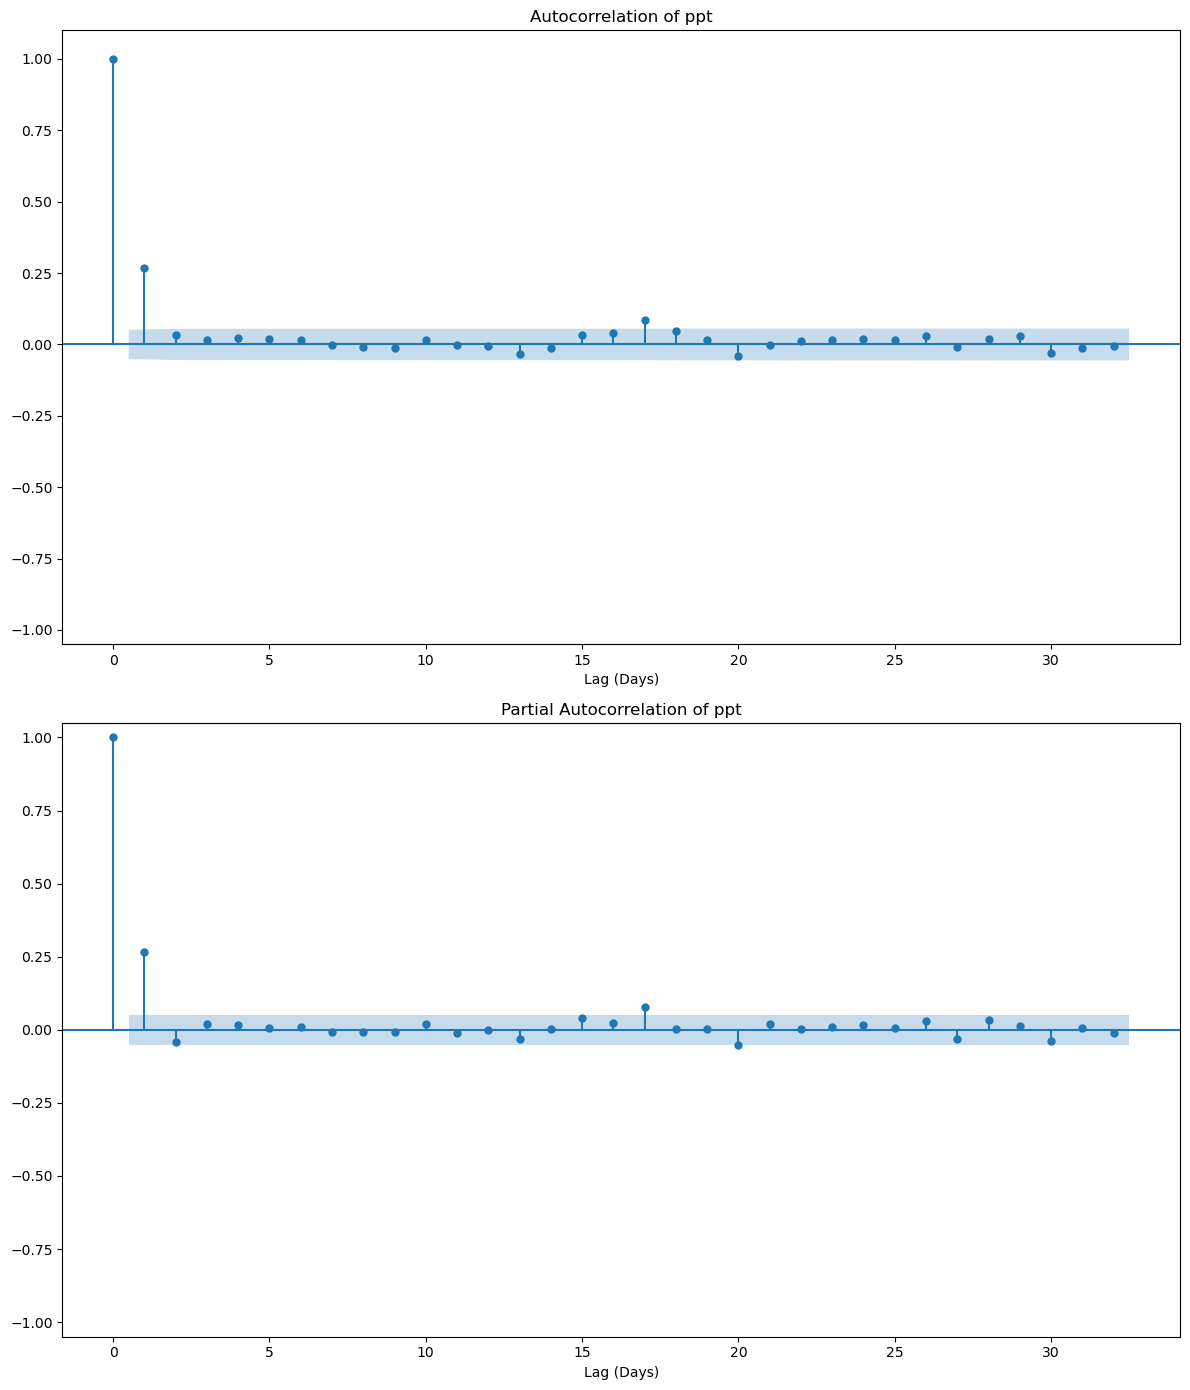

Plot saved at ACF_PACF_tmean.png


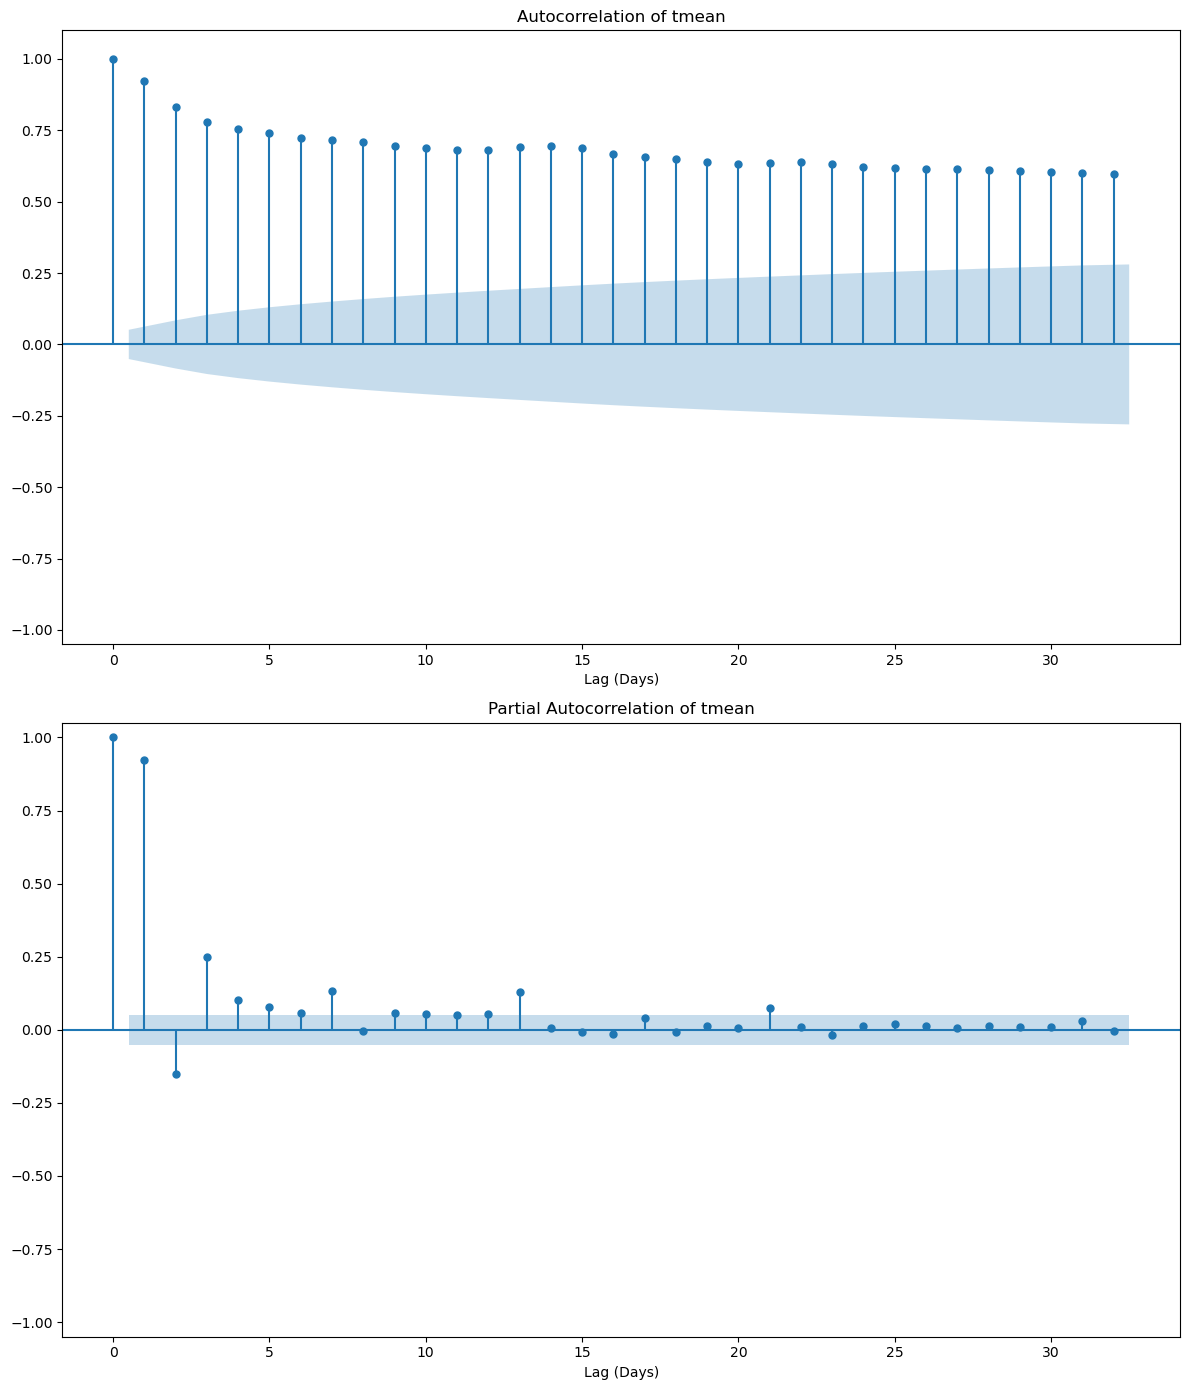

Plot saved at ACF_PACF_twbs.png


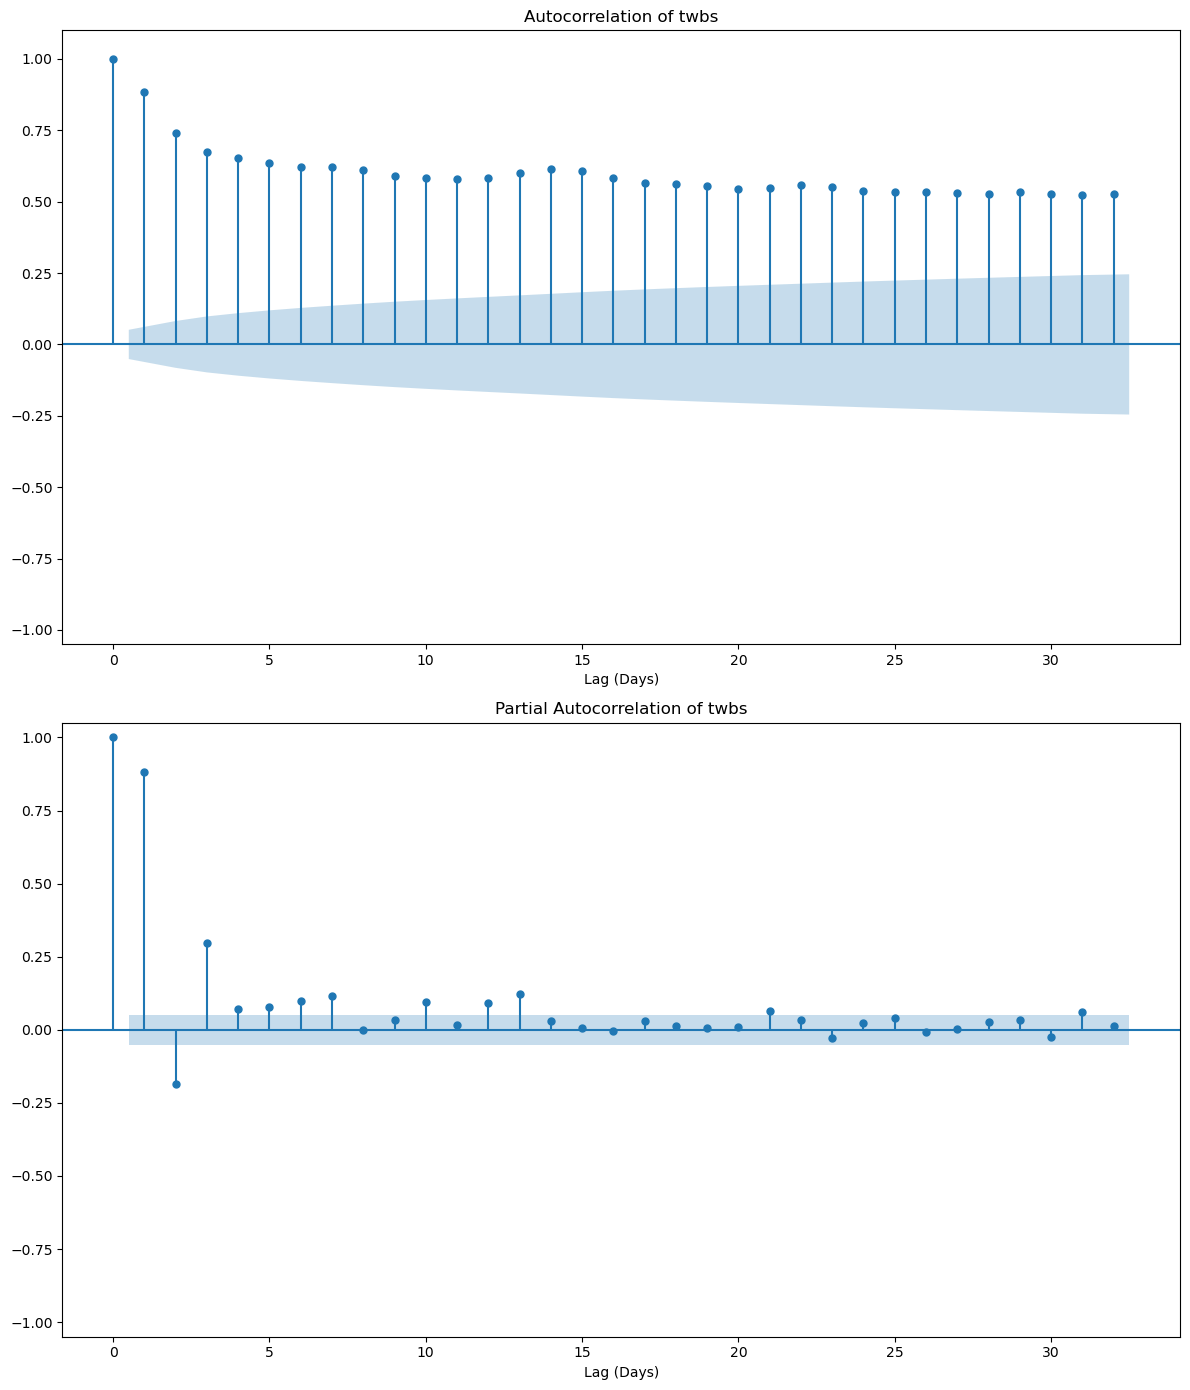

In [8]:
for var in variables: 
    file_path = os.path.join(home, var, 'netcdf' , f'Harris_County_PRISM_{var}_stable_4km{daily}_{years[0]}_{years[-1]}.nc') 
    ds = xr.open_dataset(file_path)

    da = ds[var]  
    ts = da.values

    plot_acf_pacf(ts, var)

In [29]:
import matplotlib.pyplot as plt
from scipy.signal import detrend 
import pandas as pd
from scipy import stats
variables = ['twbs', 'ppt']
years = ['2020', '2021', '2022']
daily = "D2"
# fig, ax = plt.subplots(1,1, figsize = (10,4))
home = '/home/sd96/rdf'


paths = {'ppt': os.path.join(home, 'ppt', 'netcdf', 'Harris_County_PRISM_ppt_stable_4kmD2_2020_2023.nc'), 
         'twbs': os.path.join(home, 'twbs', 'netcdf', 'Harris_County_PRISM_twbs_stable_4kmD2_2020_2023.nc')}

ppt = xr.open_dataset(paths['ppt'])
df_ppt = ppt.to_dataframe()

twbs = xr.open_dataset(paths['twbs'])

twbs_vector = twbs['twbs'].values

# Shape becomes (1461, 1)
twbs_vector = twbs_vector.reshape(1, -1) 
print("twbs_vector shape", twbs_vector.shape) 

print(twbs_vector)
twbs_cov = np.cov(twbs_vector)
print(twbs_cov)

twbs_vector_T = twbs_vector.T 
print(np.cov(twbs_vector_T))
print("twbs_vector_T shape", twbs_vector_T.shape) 

cov_array =  twbs_vector @ twbs_vector_T

print(cov_array.shape)
precision = np.linalg.inv(cov_array)

cov_obj = stats.Covariance.from_precision(precision) 

rng = np.random.default_rng()

print(cov_array.shape)
x = rng.multivariate_normal(np.zeros(1461), cov_array, size=(10000))
x = cov_object.whiten(x)

np.cov(x_, rowvar=False)

# twbs_whitened = cov_obj.whiten(twbs)

# print("Original covariance:", np.cov(twbs.T))
# print("Whitened covariance:", np.cov(twbs_whitened.T))

# # Plot autocorrelation before and after
# plot_acf(twbs.flatten(), lags=100)
# plt.title("ACF: Original twbs")
# plt.show()

# plot_acf(twbs_whitened.flatten(), lags=100)
# plt.title("ACF: Whitened twbs")
# plt.show()

twbs_vector shape (1, 1461)
[[ 4.90382522 11.23462391 14.96761915 ...  4.43831233  3.71914247
   6.19918077]]
49.64343484130804
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
twbs_vector_T shape (1461, 1)
(1, 1)
(1, 1)


/tmp/ipykernel_29129/2172676886.py:31: RuntimeWarning: Degrees of freedom <= 0 for slice
  print(np.cov(twbs_vector_T))
/home/sd96/miniforge3/envs/conda_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/sd96/miniforge3/envs/conda_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: mean and cov must have same length

## Using Fourier Transformation

### remove_dominant_signals

In [12]:
from scipy import signal
def remove_dominant_signals(array_in, spd, fCrit):
    '''
        This function removes the dominant signal be removing the long-term linear trend,
        preserving the mean and removing signals less than a critical threshold frequency.

        Inputs:
            array_in - array of shape(nt, nx, ny)
            spd - samples per day
            fCrit - critical frequency at which to run the high-bandpass filter

        Returns:
            array_dt - array with dominant signals removed, of shape (nt, nx, ny)

    '''
    nt, nx, ny = array_in.shape

    # Remove the long term trend
    long_mean = np.mean(array_in, axis = 0)
    detrend = signal.detrend(array_in, axis = 0, type='linear')
    # Conserve the mean
    array_dt = detrend + long_mean

    # Remove seasonal and longer signals, preserving the subseasonal signal (1st three harmonics)
    fourier = np.fft.fft(array_dt, axis = 0)
    fourier_mean = np.copy(fourier[0,:,:])
    freq = np.fft.fftfreq(nt, 1./spd)
    ind = np.where(np.abs(freq)<=(fCrit))[0]
    fourier[ind,:,:] = 0.0
    # Preserve the mean
    fourier[0,:,:] = fourier_mean
    array_dt = np.fft.ifft(fourier, axis = 0)

    print("Original mean:", np.mean(array_in))
    print("Filtered mean:", np.mean(array_dt))
    print("Original variance:", np.var(array_in))
    print("Filtered variance:", np.var(array_dt))


    return array_dt

### plot_frequency

In [13]:

def plot_frequency(array, spd, title="Fourier Amplitude Spectrum"):
    # If input is 1D, reshape to (nt, 1, 1)
    if array.ndim == 1:
        array = array.reshape(-1, 1, 1)

    nt = array.shape[0]

    mean_series = np.mean(array, axis=(1, 2))

    # FFT
    freqs = np.fft.fftfreq(nt, 1./spd)
    fft_vals = np.fft.fft(mean_series)
    amplitude = np.abs(fft_vals)

    zoom_range=0.04
    mask = (freqs >= -zoom_range) & (freqs <= zoom_range) & (freqs > 0)

    plt.figure(figsize=(10, 4))
    plt.plot(freqs[mask], amplitude[mask], marker='o')
    plt.xlabel("Frequency (cycles/day)")
    plt.xticks(freqs[mask], rotation=45)
    plt.ylabel("Amplitude")
    plt.title(f"{title} (Zoomed ±{zoom_range} cycles/day)")
    plt.grid()
    plt.show()

    return freqs[mask]

### Tmean Analysis

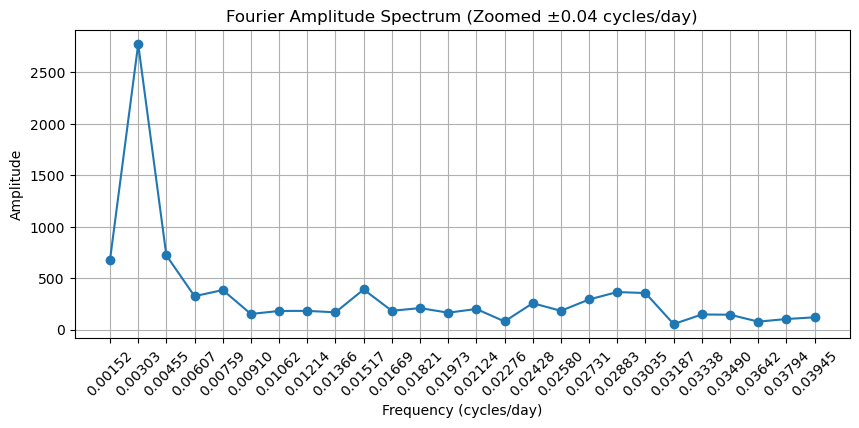

In [14]:
array_1d = df_covid_ppt_tmean_twbs['tmean'].values
array_3d = array_1d.reshape(-1, 1, 1) 

freqs = plot_frequency(array_1d, 1)


In [60]:
print(freqs)

[0.00151745 0.0030349  0.00455235 0.0060698  0.00758725 0.0091047
 0.01062215 0.01213961 0.01365706 0.01517451 0.01669196 0.01820941
 0.01972686 0.02124431 0.02276176 0.02427921 0.02579666 0.02731411
 0.02883156 0.03034901 0.03186646 0.03338392 0.03490137 0.03641882
 0.03793627 0.03945372]


Original mean: 20.64019839810685
Filtered mean: (20.64019839810683-2.8776930257023456e-17j)
Original variance: 57.15368416049196
Filtered variance: 18.10095275957382


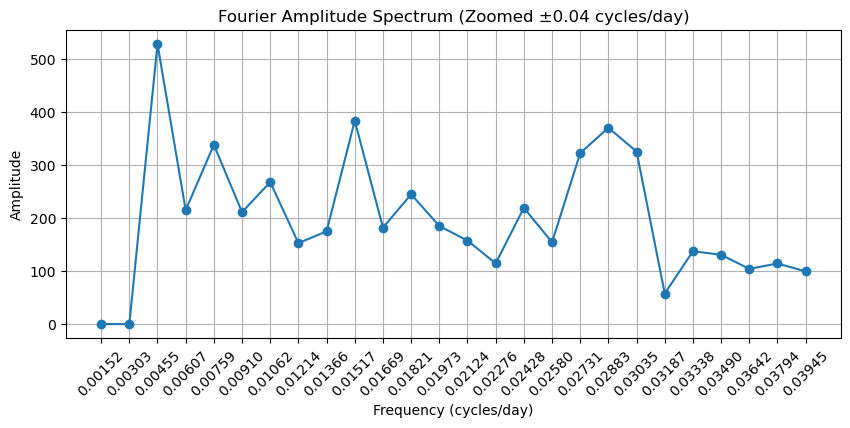

659
659


In [15]:
import numpy as np
array_1d = df_covid_ppt_tmean_twbs['tmean'].values
array_3d = array_1d.reshape(-1, 1, 1)  # shape (nt, 1, 1)

spd = 1  # samples per day

tmean_fCrit = 0.0033

filtered_array_3d = remove_dominant_signals(array_3d, spd, tmean_fCrit)

freqs = plot_frequency(filtered_array_3d, 1)
print(len(filtered_array_3d))
print(len(array_1d))

filtered_tmean = np.real(filtered_array_3d).flatten()

df_covid_ppt_tmean_twbs['tmean_filtered'] = filtered_tmean

### spline viral load

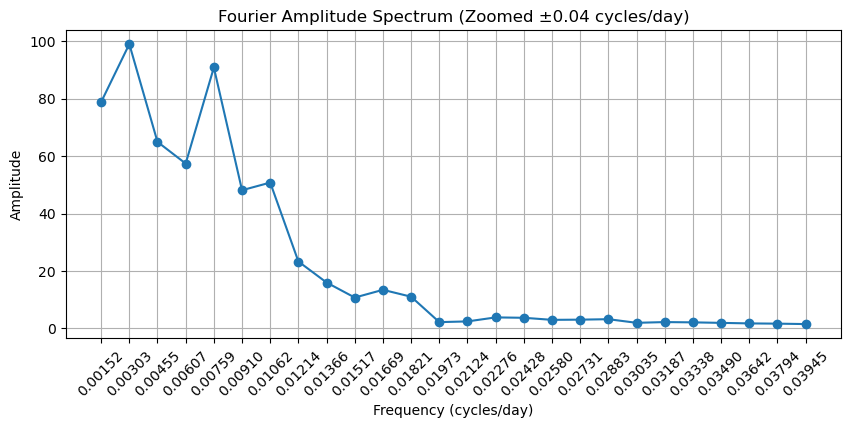

In [16]:
array_1d = df_covid_ppt_tmean_twbs['Spline_WW'].values
array_3d = array_1d.reshape(-1, 1, 1) 

freqs = plot_frequency(array_1d, 1)


Original mean: 13.500196461305006
Filtered mean: (13.50019646130499-8.95949138518158e-17j)
Original variance: 0.17505301004309132
Filtered variance: 0.14776350907050087


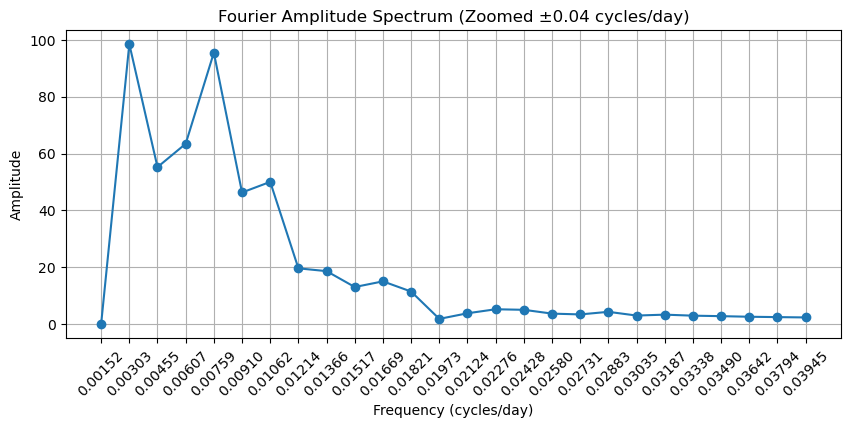

659
659


In [25]:
import numpy as np
array_1d = df_covid_ppt_tmean_twbs['Spline_WW'].values
array_3d = array_1d.reshape(-1, 1, 1)  # shape (nt, 1, 1)

spd = 1  # samples per day

spline_ww_fCrit = 0.003

filtered_array_3d = remove_dominant_signals(array_3d, spd, spline_ww_fCrit)

freqs = plot_frequency(filtered_array_3d, 1)
print(len(filtered_array_3d))
print(len(array_1d))

filtered_spline_ww = np.real(filtered_array_3d).flatten()

df_covid_ppt_tmean_twbs['spline_ww_filtered'] = filtered_spline_ww

### spline positivity rate

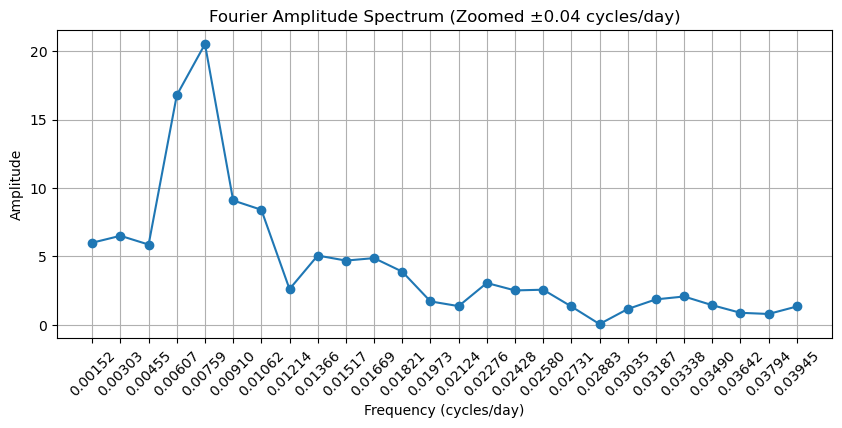

In [144]:
array_1d = df_covid_ppt_tmean_twbs['Spline_PR'].values
array_3d = array_1d.reshape(-1, 1, 1) 

freqs = plot_frequency(array_1d, 1)


Original mean: 0.10975504084977239
Filtered mean: (0.10975504084977235+1.0463620359647661e-19j)
Original variance: 0.005194740550552655
Filtered variance: 0.00019139171464559827


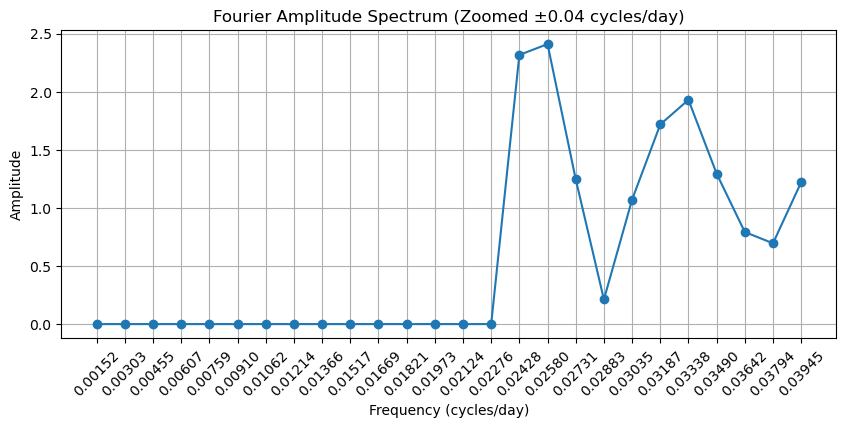

659
659


In [145]:
import numpy as np
array_1d = df_covid_ppt_tmean_twbs['Spline_PR'].values
array_3d = array_1d.reshape(-1, 1, 1)  # shape (nt, 1, 1)

spd = 1  # samples per day

spline_ww_fCrit = 0.008

filtered_array_3d = remove_dominant_signals(array_3d, spd, spline_ww_fCrit)

freqs = plot_frequency(filtered_array_3d, 1)
print(len(filtered_array_3d))
print(len(array_1d))

filtered_spline_pr = np.real(filtered_array_3d).flatten()

df_covid_ppt_tmean_twbs['spline_pr_filtered'] = filtered_spline_pr

### Tmean and Spline_WW Correlation

Shapiro-Wilk p-value: 3.0655014261565466e-07
{'0 days': 0, '15 days': 15, '30 days': 30, '45 days': 45, '60 days': 60, '75 days': 75, '90 days': 90, '105 days': 105, '120 days': 120, '135 days': 135, '150 days': 150, '165 days': 165, '180 days': 180, '195 days': 195, '210 days': 210, '225 days': 225}
df_merged 2021-02-16 00:00:00 to 2022-04-25 00:00:00
Index(['Spline_WW', 'Spline_PR', 'twbs', 'tmean', 'ppt', 'tmean_filtered',
       'spline_ww_filtered', 'tmean_filtered_lag0', 'tmean_filtered_lag15',
       'tmean_filtered_lag30', 'tmean_filtered_lag45', 'tmean_filtered_lag60',
       'tmean_filtered_lag75', 'tmean_filtered_lag90', 'tmean_filtered_lag105',
       'tmean_filtered_lag120', 'tmean_filtered_lag135',
       'tmean_filtered_lag150', 'tmean_filtered_lag165',
       'tmean_filtered_lag180', 'tmean_filtered_lag195',
       'tmean_filtered_lag210', 'tmean_filtered_lag225'],
      dtype='object')
Lag 0 days:
  spline_ww_filtered: r = 0.069, p = 0.152
Lag 15 days:
  spline_ww_filt

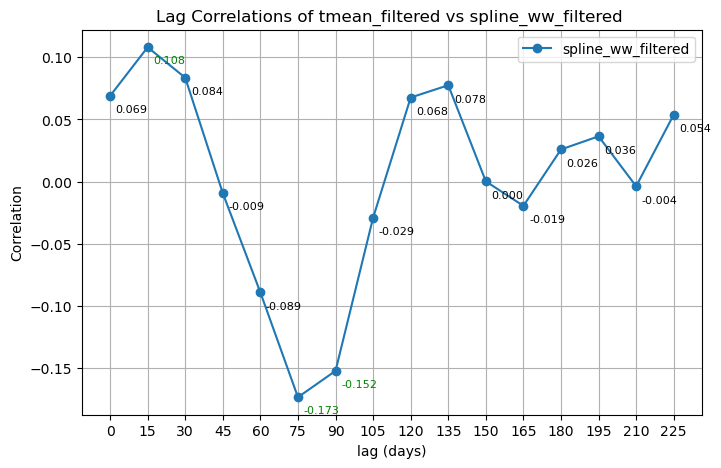

Top lags: []


,Spline_WW,Spline_PR,twbs,tmean,ppt,tmean_filtered,spline_ww_filtered,tmean_filtered_lag0,tmean_filtered_lag15,tmean_filtered_lag30,...,tmean_filtered_lag90,tmean_filtered_lag105,tmean_filtered_lag120,tmean_filtered_lag135,tmean_filtered_lag150,tmean_filtered_lag165,tmean_filtered_lag180,tmean_filtered_lag195,tmean_filtered_lag210,tmean_filtered_lag225
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-16,13.605008,0.114007,-9.421095,-7.559888,0.069657,1.024230,13.578657,1.024230,21.546367,18.362743,...,18.568584,15.210253,23.670116,17.204910,20.602357,22.920364,21.341138,22.253274,20.320812,23.446590
2021-02-17,13.595747,0.111396,-5.869660,-4.304870,3.243034,4.221571,13.567161,4.221571,20.412419,20.732376,...,19.585712,16.349660,23.957223,18.367497,18.596638,21.877415,21.200964,22.105857,20.138546,23.312833
2021-02-18,13.586673,0.110904,0.537278,1.065737,9.235779,9.531631,13.555857,9.531631,20.859789,21.461483,...,22.215279,18.159513,23.956001,18.722978,16.182935,21.515631,21.387214,21.950328,20.981415,23.509266
2021-02-19,13.577809,0.114376,-1.878005,-0.012764,0.000000,8.389727,13.544771,8.389727,23.296790,27.861645,...,25.005142,20.647990,24.182114,18.800524,17.360183,21.877685,20.008952,21.997224,22.631433,23.981795
2021-02-20,13.569179,0.116054,-0.206894,2.886171,0.000000,11.222425,13.533925,11.222425,27.669238,25.297789,...,24.636956,20.259346,24.722691,19.734349,18.843563,21.870043,21.433471,21.945577,21.889436,23.592986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-21,13.416142,0.045910,21.569155,24.901172,0.000000,24.875471,13.470657,24.875471,27.730130,23.103820,...,11.542218,24.912081,17.135894,24.496969,24.275886,15.830678,24.680691,22.195737,16.584589,20.427885
2022-04-22,13.447710,0.046127,21.954531,25.512130,0.000000,25.407014,13.502280,25.407014,20.791517,17.664056,...,12.065237,19.316400,21.858315,20.816156,18.701893,17.319188,24.133023,22.421349,16.647473,21.030675
2022-04-23,13.480710,0.047806,20.734224,24.835808,0.000000,24.652727,13.535318,24.652727,17.904024,16.727824,...,12.911896,15.886946,26.124120,24.051786,18.829544,19.596720,26.473188,22.847061,17.332553,21.195052


In [26]:


plot_lagged_correlations(df_covid_ppt_tmean_twbs, 'tmean_filtered', 'spline_ww_filtered', interval_size=15, number_of_intervals=15)


# plot_lagged_correlations(df_covid_ppt_tmean_twbs, f'whitened_{var}_AR({lag})', f'Spline_WW_whitened_{covid_lag}', 
#                          interval_size=int_size, number_of_intervals=num_ints)

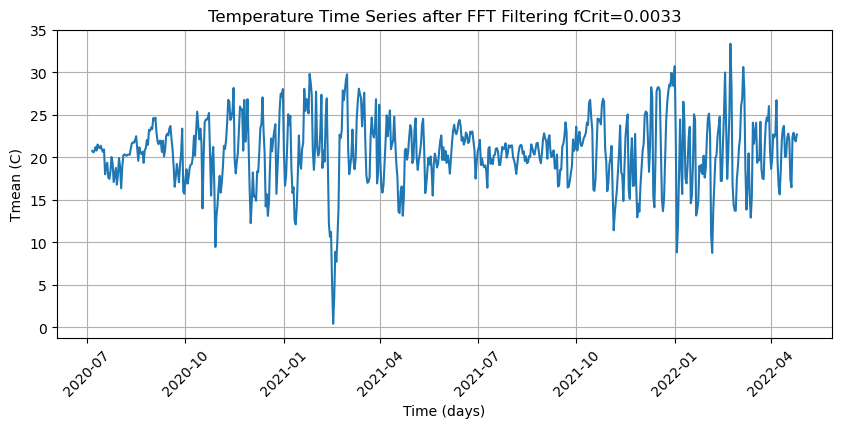

In [114]:
plt.figure(figsize=(10, 4))
plt.plot(df_covid_ppt_tmean_twbs.index, df_covid_ppt_tmean_twbs['tmean_filtered'])
plt.xlabel("Time (days)")
plt.xticks(rotation=45)
plt.ylabel("Tmean (C)")
plt.title(f"Temperature Time Series after FFT Filtering fCrit={tmean_fCrit}")
plt.grid()
plt.show()

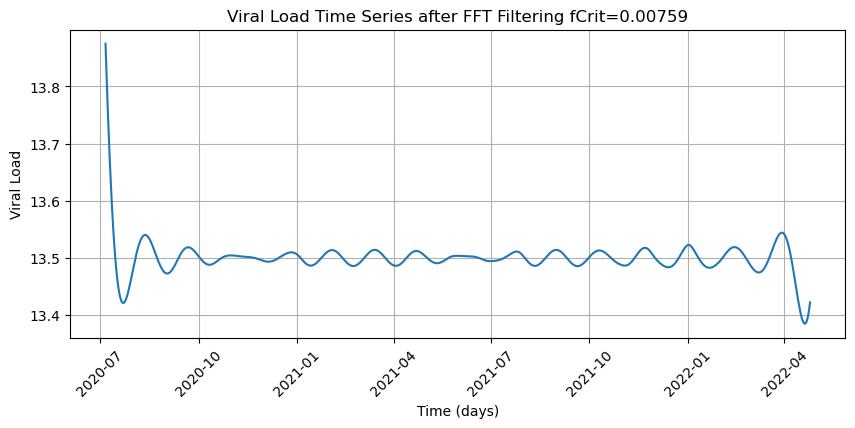

In [115]:
plt.figure(figsize=(10, 4))
plt.plot(df_covid_ppt_tmean_twbs.index, df_covid_ppt_tmean_twbs['spline_ww_filtered'])
plt.xlabel("Time (days)")
plt.xticks(rotation=45)
plt.ylabel("Viral Load")
plt.title(f"Viral Load Time Series after FFT Filtering fCrit={spline_ww_fCrit}")
plt.grid()
plt.show()

### Tmean and Spline_PR Correlation

Shapiro-Wilk p-value: 3.0655014261565466e-07
{'0 days': 0, '4 days': 4, '8 days': 8, '12 days': 12, '16 days': 16, '20 days': 20, '24 days': 24, '28 days': 28, '32 days': 32, '36 days': 36, '40 days': 40, '44 days': 44, '48 days': 48, '52 days': 52, '56 days': 56, '60 days': 60, '64 days': 64, '68 days': 68, '72 days': 72, '76 days': 76, '80 days': 80, '84 days': 84, '88 days': 88, '92 days': 92, '96 days': 96, '100 days': 100, '104 days': 104, '108 days': 108, '112 days': 112, '116 days': 116, '120 days': 120}
df_merged 2020-11-03 00:00:00 to 2022-04-25 00:00:00
Index(['Spline_WW', 'Spline_PR', 'twbs', 'tmean', 'ppt', 'tmean_filtered',
       'spline_ww_filtered', 'twbs_filtered', 'spline_pr_filtered',
       'tmean_filtered_lag0', 'tmean_filtered_lag4', 'tmean_filtered_lag8',
       'tmean_filtered_lag12', 'tmean_filtered_lag16', 'tmean_filtered_lag20',
       'tmean_filtered_lag24', 'tmean_filtered_lag28', 'tmean_filtered_lag32',
       'tmean_filtered_lag36', 'tmean_filtered_lag40'

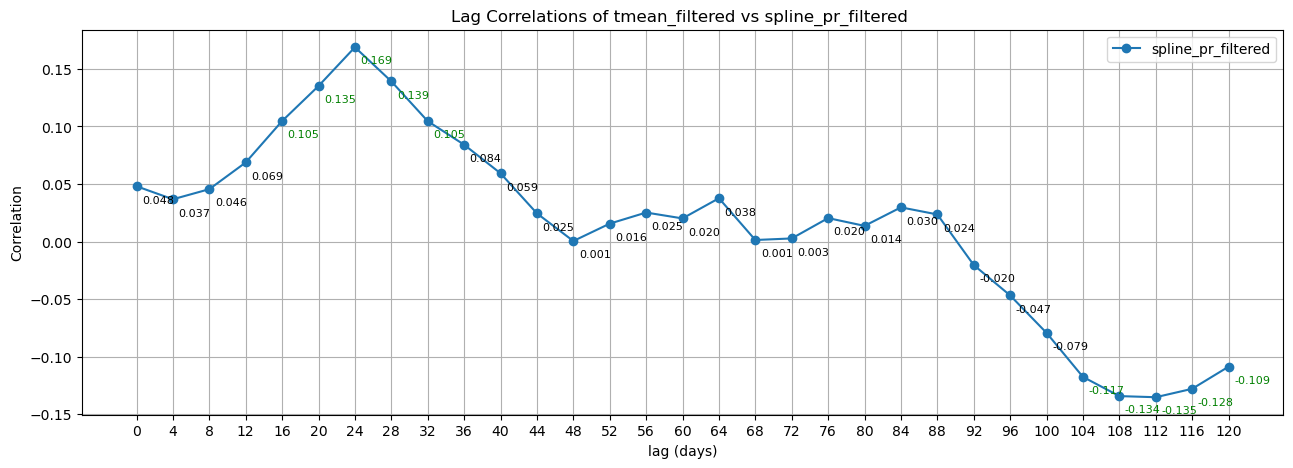

Top lags: []


,Spline_WW,Spline_PR,twbs,tmean,ppt,tmean_filtered,spline_ww_filtered,twbs_filtered,spline_pr_filtered,tmean_filtered_lag0,...,tmean_filtered_lag84,tmean_filtered_lag88,tmean_filtered_lag92,tmean_filtered_lag96,tmean_filtered_lag100,tmean_filtered_lag104,tmean_filtered_lag108,tmean_filtered_lag112,tmean_filtered_lag116,tmean_filtered_lag120
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-03,13.406405,0.073256,9.022269,14.777260,0.000000,15.210253,13.510230,15.210253,0.137119,15.210253,...,22.527629,21.950328,20.821713,20.302546,19.589874,20.138546,20.789443,24.196628,23.592986,23.446590
2020-11-04,13.412280,0.073738,10.419305,15.762568,0.000000,16.349660,13.496325,16.349660,0.135232,16.349660,...,23.069917,21.997224,22.183784,22.140574,20.401513,20.981415,21.662492,23.723203,24.327893,23.312833
2020-11-05,13.418391,0.075006,15.182959,17.418214,0.017567,18.159513,13.482629,18.159513,0.134039,18.159513,...,23.095567,21.945577,22.253274,21.039904,21.159207,22.631433,22.103142,23.455504,23.973142,23.509266
2020-11-06,13.424766,0.076283,16.686602,19.752425,0.000000,20.647990,13.469200,20.647990,0.132766,20.647990,...,22.980487,21.860319,22.105857,18.461529,19.131586,21.889436,20.320812,23.741701,23.918078,23.981795
2020-11-07,13.431428,0.078411,15.593623,19.209510,0.000000,20.259346,13.456090,20.259346,0.132263,20.259346,...,23.234874,22.527629,21.950328,20.821713,20.302546,19.589874,20.138546,20.789443,24.196628,23.592986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-21,13.416142,0.045910,21.569155,24.901172,0.000000,24.875471,13.714109,24.875471,0.071306,24.875471,...,15.630514,12.911896,23.713259,22.809032,17.336561,19.316400,9.657680,30.032987,29.416749,17.135894
2022-04-22,13.447710,0.046127,21.954531,25.512130,0.000000,25.407014,13.732734,25.407014,0.068156,25.407014,...,17.683572,16.982685,22.993704,13.684108,16.579482,15.886946,12.671681,29.566389,30.166051,21.858315
2022-04-23,13.480710,0.047806,20.734224,24.835808,0.000000,24.652727,13.752842,24.652727,0.066446,24.652727,...,14.993152,16.188241,11.542218,14.394217,18.605885,26.597737,18.425672,31.792464,29.859925,26.124120


In [139]:


plot_lagged_correlations(df_covid_ppt_tmean_twbs, 'tmean_filtered', 'spline_pr_filtered', interval_size=4, number_of_intervals=30)


# plot_lagged_correlations(df_covid_ppt_tmean_twbs, f'whitened_{var}_AR({lag})', f'Spline_WW_whitened_{covid_lag}', 
#                          interval_size=int_size, number_of_intervals=num_ints)

### Twbs Analysis

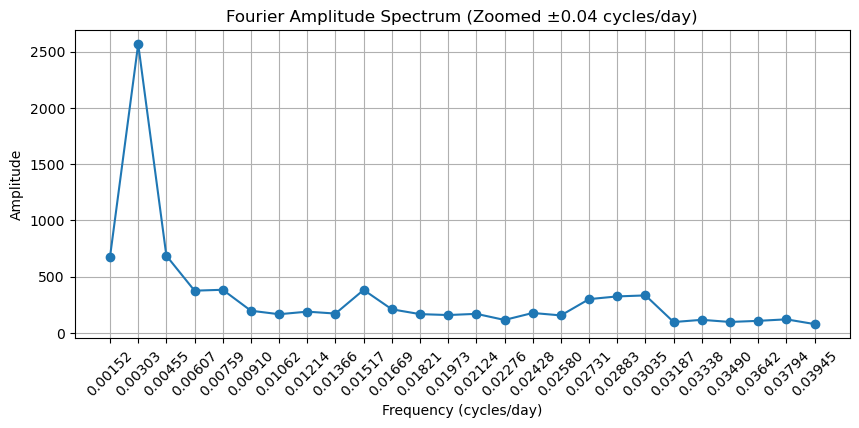

In [133]:
array_1d = df_covid_ppt_tmean_twbs['twbs'].values
array_3d = array_1d.reshape(-1, 1, 1) 

freqs = plot_frequency(array_1d, 1)


Original mean: 20.64019839810685
Filtered mean: (20.64019839810683-2.8776930257023456e-17j)
Original variance: 57.15368416049196
Filtered variance: 18.10095275957382


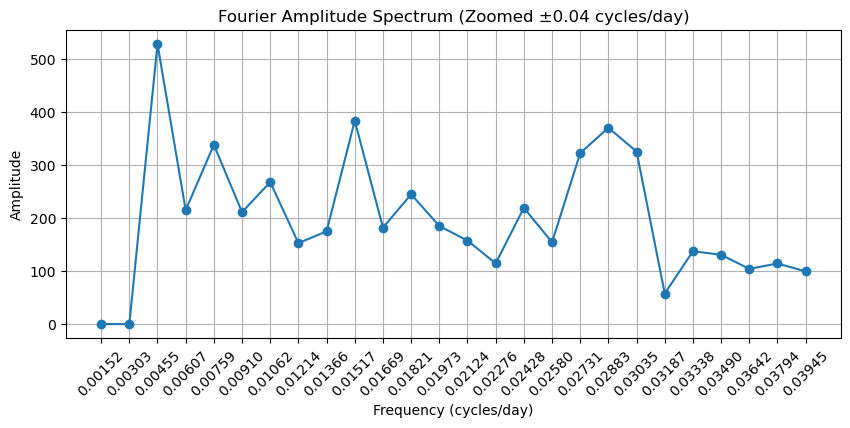

659
659


In [134]:
import numpy as np
array_1d = df_covid_ppt_tmean_twbs['tmean'].values
array_3d = array_1d.reshape(-1, 1, 1)  # shape (nt, 1, 1)

spd = 1  # samples per day

twbs_fCrit = 0.0033 / 3

filtered_array_3d = remove_dominant_signals(array_3d, spd, tmean_fCrit)

freqs = plot_frequency(filtered_array_3d, 1)
print(len(filtered_array_3d))
print(len(array_1d))

filtered_twbs = np.real(filtered_array_3d).flatten()

df_covid_ppt_tmean_twbs['twbs_filtered'] = filtered_twbs

Shapiro-Wilk p-value: 3.0655014261565466e-07
{'0 days': 0, '4 days': 4, '8 days': 8, '12 days': 12, '16 days': 16, '20 days': 20, '24 days': 24, '28 days': 28, '32 days': 32, '36 days': 36, '40 days': 40, '44 days': 44, '48 days': 48, '52 days': 52, '56 days': 56, '60 days': 60, '64 days': 64, '68 days': 68, '72 days': 72, '76 days': 76, '80 days': 80, '84 days': 84, '88 days': 88, '92 days': 92, '96 days': 96, '100 days': 100, '104 days': 104, '108 days': 108, '112 days': 112, '116 days': 116, '120 days': 120}
df_merged 2020-11-03 00:00:00 to 2022-04-25 00:00:00
Index(['Spline_WW', 'Spline_PR', 'twbs', 'tmean', 'ppt', 'tmean_filtered',
       'spline_ww_filtered', 'twbs_filtered', 'twbs_filtered_lag0',
       'twbs_filtered_lag4', 'twbs_filtered_lag8', 'twbs_filtered_lag12',
       'twbs_filtered_lag16', 'twbs_filtered_lag20', 'twbs_filtered_lag24',
       'twbs_filtered_lag28', 'twbs_filtered_lag32', 'twbs_filtered_lag36',
       'twbs_filtered_lag40', 'twbs_filtered_lag44', 'twbs_fi

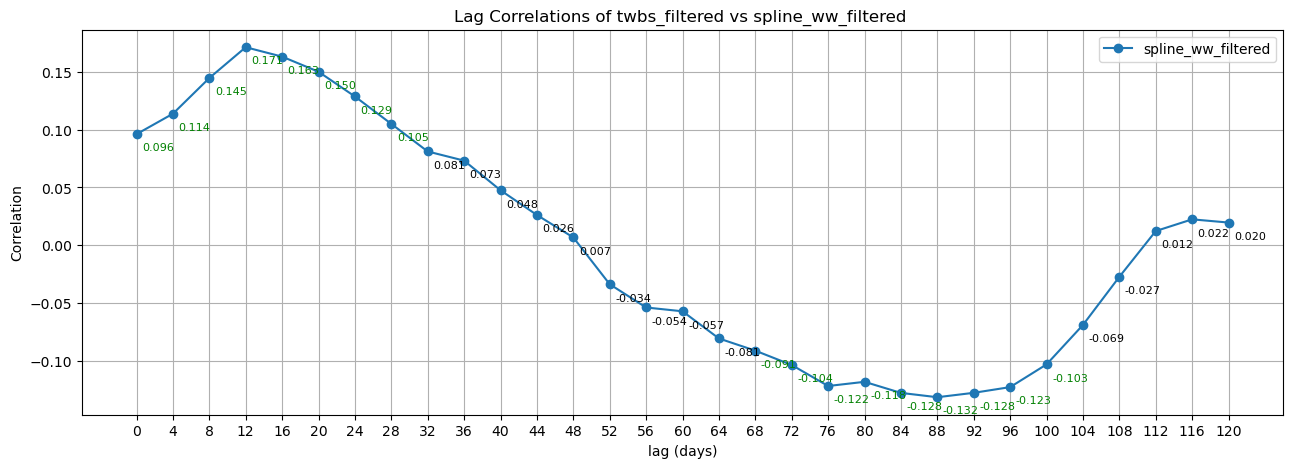

Top lags: []


,Spline_WW,Spline_PR,twbs,tmean,ppt,tmean_filtered,spline_ww_filtered,twbs_filtered,twbs_filtered_lag0,twbs_filtered_lag4,...,twbs_filtered_lag84,twbs_filtered_lag88,twbs_filtered_lag92,twbs_filtered_lag96,twbs_filtered_lag100,twbs_filtered_lag104,twbs_filtered_lag108,twbs_filtered_lag112,twbs_filtered_lag116,twbs_filtered_lag120
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-03,13.406405,0.073256,9.022269,14.777260,0.000000,15.210253,13.510230,15.210253,15.210253,12.527058,...,22.527629,21.950328,20.821713,20.302546,19.589874,20.138546,20.789443,24.196628,23.592986,23.446590
2020-11-04,13.412280,0.073738,10.419305,15.762568,0.000000,16.349660,13.496325,16.349660,16.349660,13.797633,...,23.069917,21.997224,22.183784,22.140574,20.401513,20.981415,21.662492,23.723203,24.327893,23.312833
2020-11-05,13.418391,0.075006,15.182959,17.418214,0.017567,18.159513,13.482629,18.159513,18.159513,15.778321,...,23.095567,21.945577,22.253274,21.039904,21.159207,22.631433,22.103142,23.455504,23.973142,23.509266
2020-11-06,13.424766,0.076283,16.686602,19.752425,0.000000,20.647990,13.469200,20.647990,20.647990,17.199682,...,22.980487,21.860319,22.105857,18.461529,19.131586,21.889436,20.320812,23.741701,23.918078,23.981795
2020-11-07,13.431428,0.078411,15.593623,19.209510,0.000000,20.259346,13.456090,20.259346,20.259346,15.210253,...,23.234874,22.527629,21.950328,20.821713,20.302546,19.589874,20.138546,20.789443,24.196628,23.592986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-21,13.416142,0.045910,21.569155,24.901172,0.000000,24.875471,13.714109,24.875471,24.875471,24.949957,...,15.630514,12.911896,23.713259,22.809032,17.336561,19.316400,9.657680,30.032987,29.416749,17.135894
2022-04-22,13.447710,0.046127,21.954531,25.512130,0.000000,25.407014,13.732734,25.407014,25.407014,24.319748,...,17.683572,16.982685,22.993704,13.684108,16.579482,15.886946,12.671681,29.566389,30.166051,21.858315
2022-04-23,13.480710,0.047806,20.734224,24.835808,0.000000,24.652727,13.752842,24.652727,24.652727,19.738370,...,14.993152,16.188241,11.542218,14.394217,18.605885,26.597737,18.425672,31.792464,29.859925,26.124120


In [135]:
plot_lagged_correlations(df_covid_ppt_tmean_twbs, 'twbs_filtered', 'spline_ww_filtered', interval_size=4, number_of_intervals=30)


# plot_lagged_correlations(df_covid_ppt_tmean_twbs, f'whitened_{var}_AR({lag})', f'Spline_WW_whitened_{covid_lag}', 
#                          interval_size=int_size, number_of_intervals=num_ints)

Shapiro-Wilk p-value: 3.0655014261565466e-07
{'0 days': 0, '4 days': 4, '8 days': 8, '12 days': 12, '16 days': 16, '20 days': 20, '24 days': 24, '28 days': 28, '32 days': 32, '36 days': 36, '40 days': 40, '44 days': 44, '48 days': 48, '52 days': 52, '56 days': 56, '60 days': 60, '64 days': 64, '68 days': 68, '72 days': 72, '76 days': 76, '80 days': 80, '84 days': 84, '88 days': 88, '92 days': 92, '96 days': 96, '100 days': 100, '104 days': 104, '108 days': 108, '112 days': 112, '116 days': 116, '120 days': 120}
df_merged 2020-11-03 00:00:00 to 2022-04-25 00:00:00
Index(['Spline_WW', 'Spline_PR', 'twbs', 'tmean', 'ppt', 'tmean_filtered',
       'spline_ww_filtered', 'twbs_filtered', 'spline_pr_filtered',
       'twbs_filtered_lag0', 'twbs_filtered_lag4', 'twbs_filtered_lag8',
       'twbs_filtered_lag12', 'twbs_filtered_lag16', 'twbs_filtered_lag20',
       'twbs_filtered_lag24', 'twbs_filtered_lag28', 'twbs_filtered_lag32',
       'twbs_filtered_lag36', 'twbs_filtered_lag40', 'twbs_fil

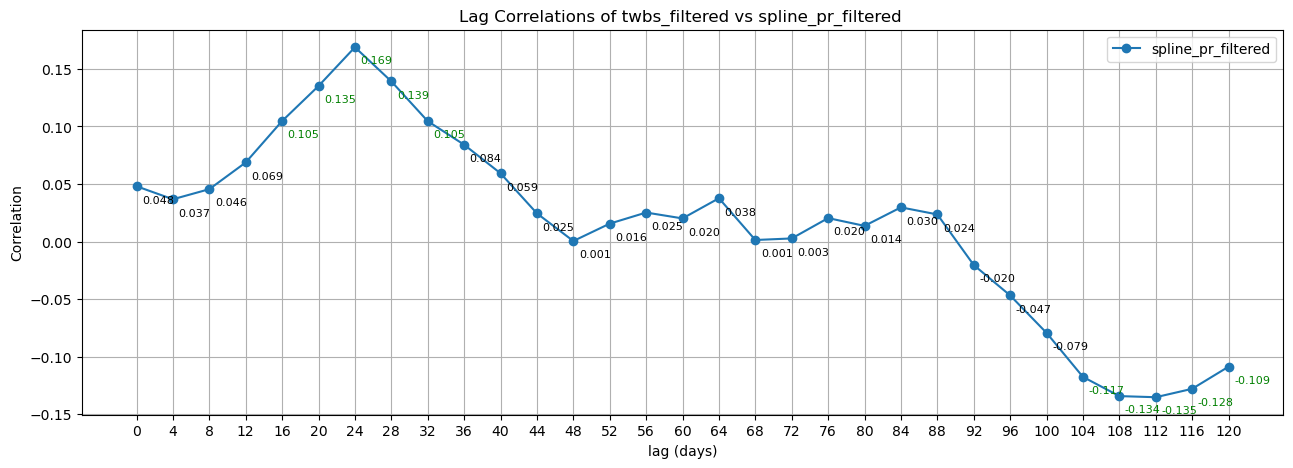

Top lags: []


,Spline_WW,Spline_PR,twbs,tmean,ppt,tmean_filtered,spline_ww_filtered,twbs_filtered,spline_pr_filtered,twbs_filtered_lag0,...,twbs_filtered_lag84,twbs_filtered_lag88,twbs_filtered_lag92,twbs_filtered_lag96,twbs_filtered_lag100,twbs_filtered_lag104,twbs_filtered_lag108,twbs_filtered_lag112,twbs_filtered_lag116,twbs_filtered_lag120
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-03,13.406405,0.073256,9.022269,14.777260,0.000000,15.210253,13.510230,15.210253,0.137119,15.210253,...,22.527629,21.950328,20.821713,20.302546,19.589874,20.138546,20.789443,24.196628,23.592986,23.446590
2020-11-04,13.412280,0.073738,10.419305,15.762568,0.000000,16.349660,13.496325,16.349660,0.135232,16.349660,...,23.069917,21.997224,22.183784,22.140574,20.401513,20.981415,21.662492,23.723203,24.327893,23.312833
2020-11-05,13.418391,0.075006,15.182959,17.418214,0.017567,18.159513,13.482629,18.159513,0.134039,18.159513,...,23.095567,21.945577,22.253274,21.039904,21.159207,22.631433,22.103142,23.455504,23.973142,23.509266
2020-11-06,13.424766,0.076283,16.686602,19.752425,0.000000,20.647990,13.469200,20.647990,0.132766,20.647990,...,22.980487,21.860319,22.105857,18.461529,19.131586,21.889436,20.320812,23.741701,23.918078,23.981795
2020-11-07,13.431428,0.078411,15.593623,19.209510,0.000000,20.259346,13.456090,20.259346,0.132263,20.259346,...,23.234874,22.527629,21.950328,20.821713,20.302546,19.589874,20.138546,20.789443,24.196628,23.592986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-21,13.416142,0.045910,21.569155,24.901172,0.000000,24.875471,13.714109,24.875471,0.071306,24.875471,...,15.630514,12.911896,23.713259,22.809032,17.336561,19.316400,9.657680,30.032987,29.416749,17.135894
2022-04-22,13.447710,0.046127,21.954531,25.512130,0.000000,25.407014,13.732734,25.407014,0.068156,25.407014,...,17.683572,16.982685,22.993704,13.684108,16.579482,15.886946,12.671681,29.566389,30.166051,21.858315
2022-04-23,13.480710,0.047806,20.734224,24.835808,0.000000,24.652727,13.752842,24.652727,0.066446,24.652727,...,14.993152,16.188241,11.542218,14.394217,18.605885,26.597737,18.425672,31.792464,29.859925,26.124120


In [140]:
plot_lagged_correlations(df_covid_ppt_tmean_twbs, 'twbs_filtered', 'spline_pr_filtered', interval_size=4, number_of_intervals=30)


# plot_lagged_correlations(df_covid_ppt_tmean_twbs, f'whitened_{var}_AR({lag})', f'Spline_WW_whitened_{covid_lag}', 
#                          interval_size=int_size, number_of_intervals=num_ints)